### Import libraries

In [1]:
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Read in hotfilm
Reading in one single dataset for now as proof of concept. Future work will read in all hotfilm data, likely using glob. One dataset contains two hours of data (in this case).

In [2]:
# Read in single dataset
hotfilm = xr.open_dataset('/scr/isfs/projects/M2HATS/netcdf/hotfilm.20241219/hotfilm_volts_20230905_000000_120.nc')

In [3]:
# Average every 1 second
hotfilm_1s_avg = hotfilm.resample(time='1s').mean()

# Offset by .5 seconds per ISFS standard
hotfilm_1s_avg['time'] = hotfilm_1s_avg['time'] + np.timedelta64(500, 'ms')

# Remove last time point as it is not a full second
hotfilm_1s_avg = hotfilm_1s_avg.isel(time=slice(0, -1))

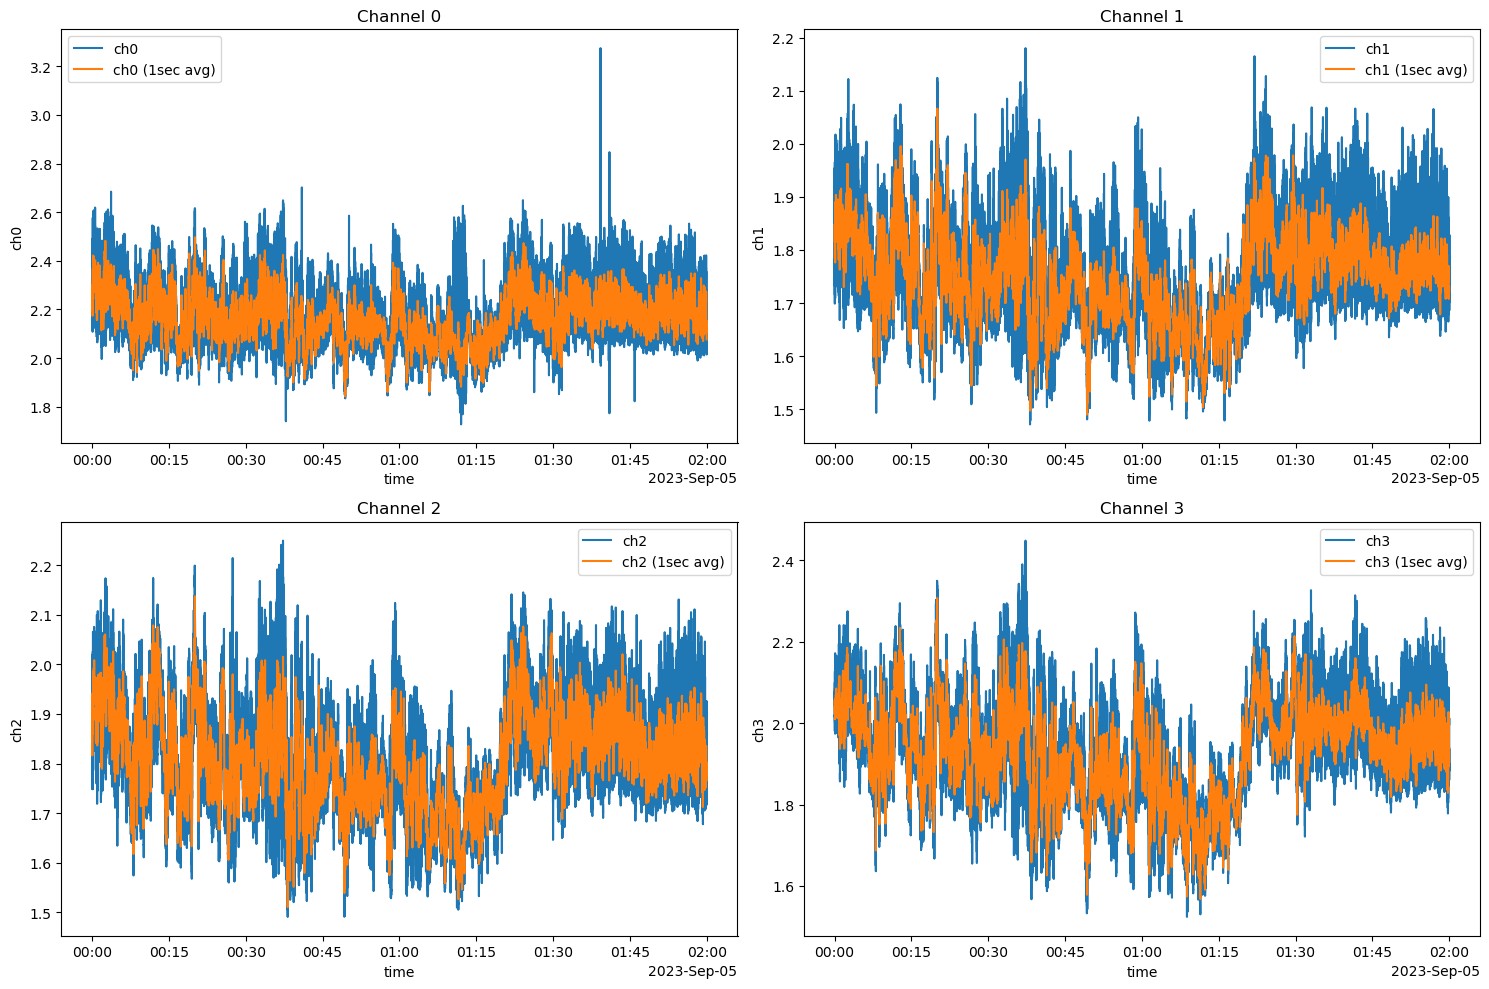

In [4]:
# Visualize hotfilm data, instantaneous and 1sec average
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot ch0
hotfilm['ch0'].plot.line(ax=axs[0, 0], label='ch0')
hotfilm_1s_avg['ch0'].plot.line(ax=axs[0, 0], label='ch0 (1sec avg)')
axs[0, 0].set_title('Channel 0')
axs[0, 0].legend()

# Plot ch1
hotfilm['ch1'].plot.line(ax=axs[0, 1], label='ch1')
hotfilm_1s_avg['ch1'].plot.line(ax=axs[0, 1], label='ch1 (1sec avg)')
axs[0, 1].set_title('Channel 1')
axs[0, 1].legend()

# Plot ch2
hotfilm['ch2'].plot.line(ax=axs[1, 0], label='ch2')
hotfilm_1s_avg['ch2'].plot.line(ax=axs[1, 0], label='ch2 (1sec avg)')
axs[1, 0].set_title('Channel 2')
axs[1, 0].legend()

# Plot ch3
hotfilm['ch3'].plot.line(ax=axs[1, 1], label='ch3')
hotfilm_1s_avg['ch3'].plot.line(ax=axs[1, 1], label='ch3 (1sec avg)')
axs[1, 1].set_title('Channel 3')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

### Read in sonics
Need to read in non-tilt corrected to align with hotfilm -- don't know where to find these and need to look. This dataset is a placeholder.

In [5]:
# Define the directory containing 1-second sonic datasets
data_dir = '/scr/isfs/projects/M2HATS/netcdf/hr_qc_geo_tiltcor.20240816/'

# Use glob to find all dataset files in the directory
dataset_files = glob.glob(os.path.join(data_dir, 'isfs_m2hats_qc_geo_tiltcor_hr_20230905_0[0-1]0000.nc'))

# Read in the datasets
datasets = []
for file in dataset_files:
    ds = xr.open_dataset(file)
    
    # xarray is reading the time dimension as date & "00" regardless of actual file time, so adjusting with filename. 
    # Kind of hacky, but will be using a different sonic dataset to perform the real analysis, so this won't make the final code.
    hour = int(file.split('_')[-1][:2])  # Extract the hour from the filename
    ds['time'] = ds['time'] + np.timedelta64(hour, 'h')  # Adjust the time dimension
    datasets.append(ds)

# Concatenate the datasets along the time dimension
sonic_dataset = xr.concat(datasets, dim='time')

### Compare
Creating calibration curves and plotting voltage vs. wind speed. This section is still a work in progress, and I have to:
1. Rotate the wind vector (hopefully by using sonic data not qc'd for tilt correction?)
2. Further understand and implement the calibration equation using Steve's code and https://www.thermopedia.com/content/853/

**It's important to note that these calibration curves are NOT correct. Just the beginning of the concept.**

In [6]:
# Define a function to plot hotfilm vs sonic data and a calibration curve
def plot_scatter_and_curve(ax, sonic_data, hotfilm_data, title, xlabel, ylabel):
    # Create scatter plot of hotfilm vs sonic data
    ax.scatter(hotfilm_data**2, sonic_data**.45)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Fit the data to a linear model
    # Ensure the data passed to np.polyfit does not contain NaN or infinite values
    valid_mask = np.isfinite(hotfilm_data**2) & np.isfinite(sonic_data**.45)
    a, b = np.polyfit(hotfilm_data[valid_mask]**2, sonic_data[valid_mask]**.45, 1)

    # Generate the y-values for the trendline
    x_trend = np.linspace(min(hotfilm_data**2), max(hotfilm_data**2), 100)
    y_trend = a * x_trend + b

    # Plot the trendline
    ax.plot(x_trend, y_trend, color='red', label=f'Trendline (U^.45 = {a:.2f}*Eb^2 + {b:.2f})')
    ax.legend()
    
    # Add a flag if fewer than 100 points
    if len(hotfilm_data) < 100:
        flag = True
    else:
        flag = False
        
    return a, b, flag

In [7]:
# I'm not sure what sample is in this dataset, will have to ask someone or sleuth around. Probably won't matter when I switch to non-tilt-corrected?
# Anyways, chose sample 0 / 60 for now 
sonic_dataset = sonic_dataset.isel(sample=0)

### Visualize comparisons
For a sanity check. Don't see a purpose for making plots outside of a check, so the plotting function will go away as soon as I become confident in the methods. 

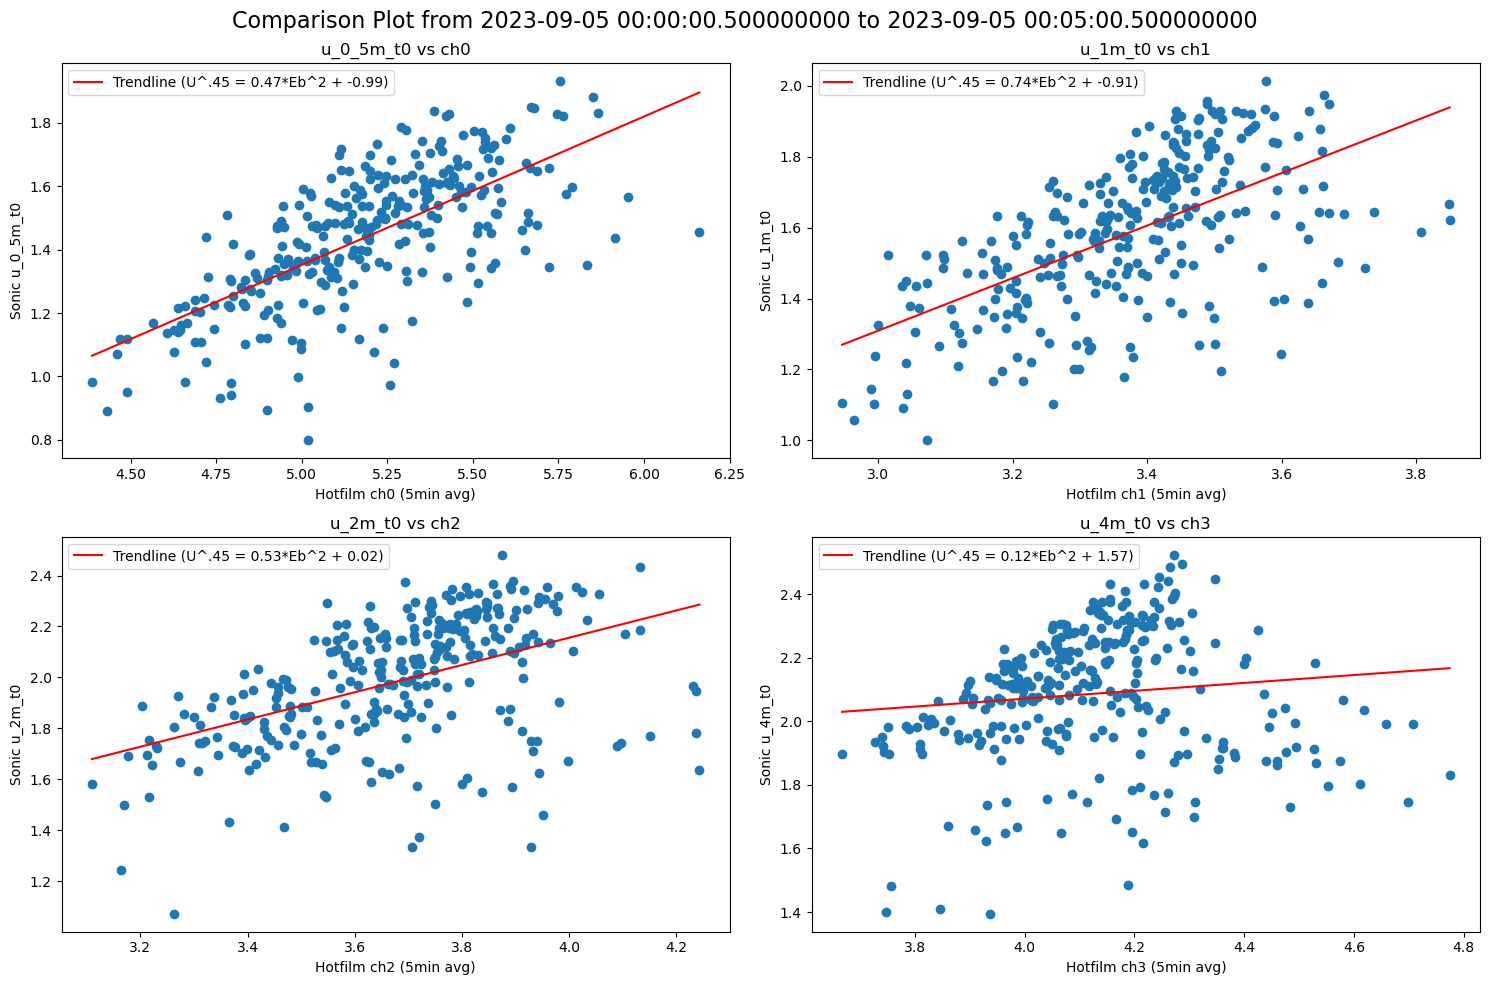

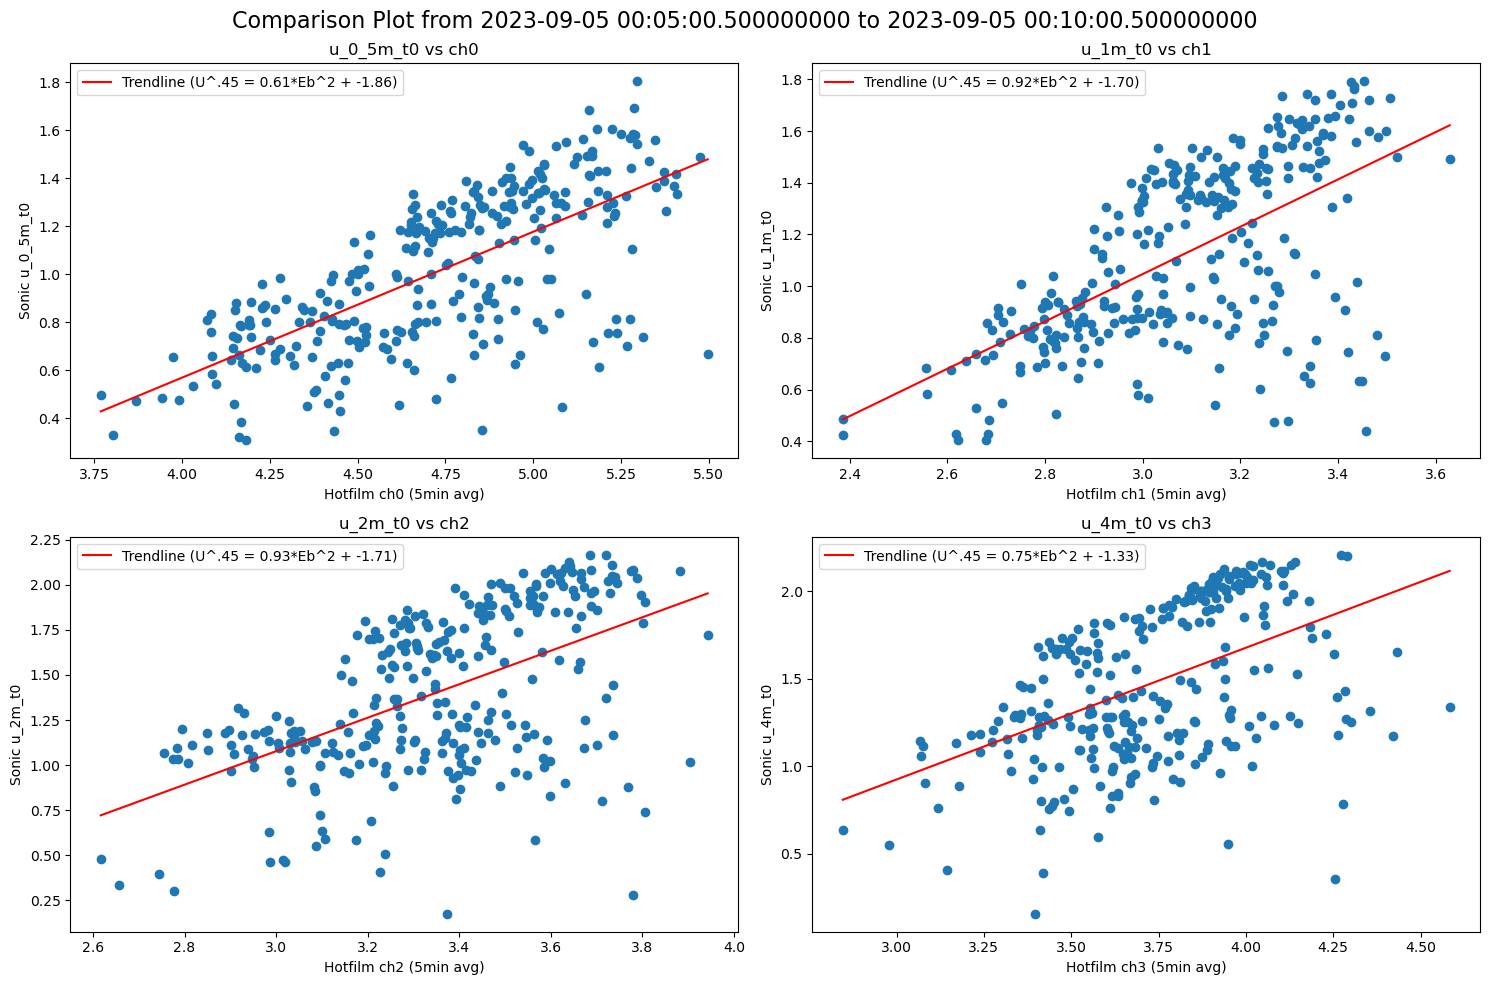

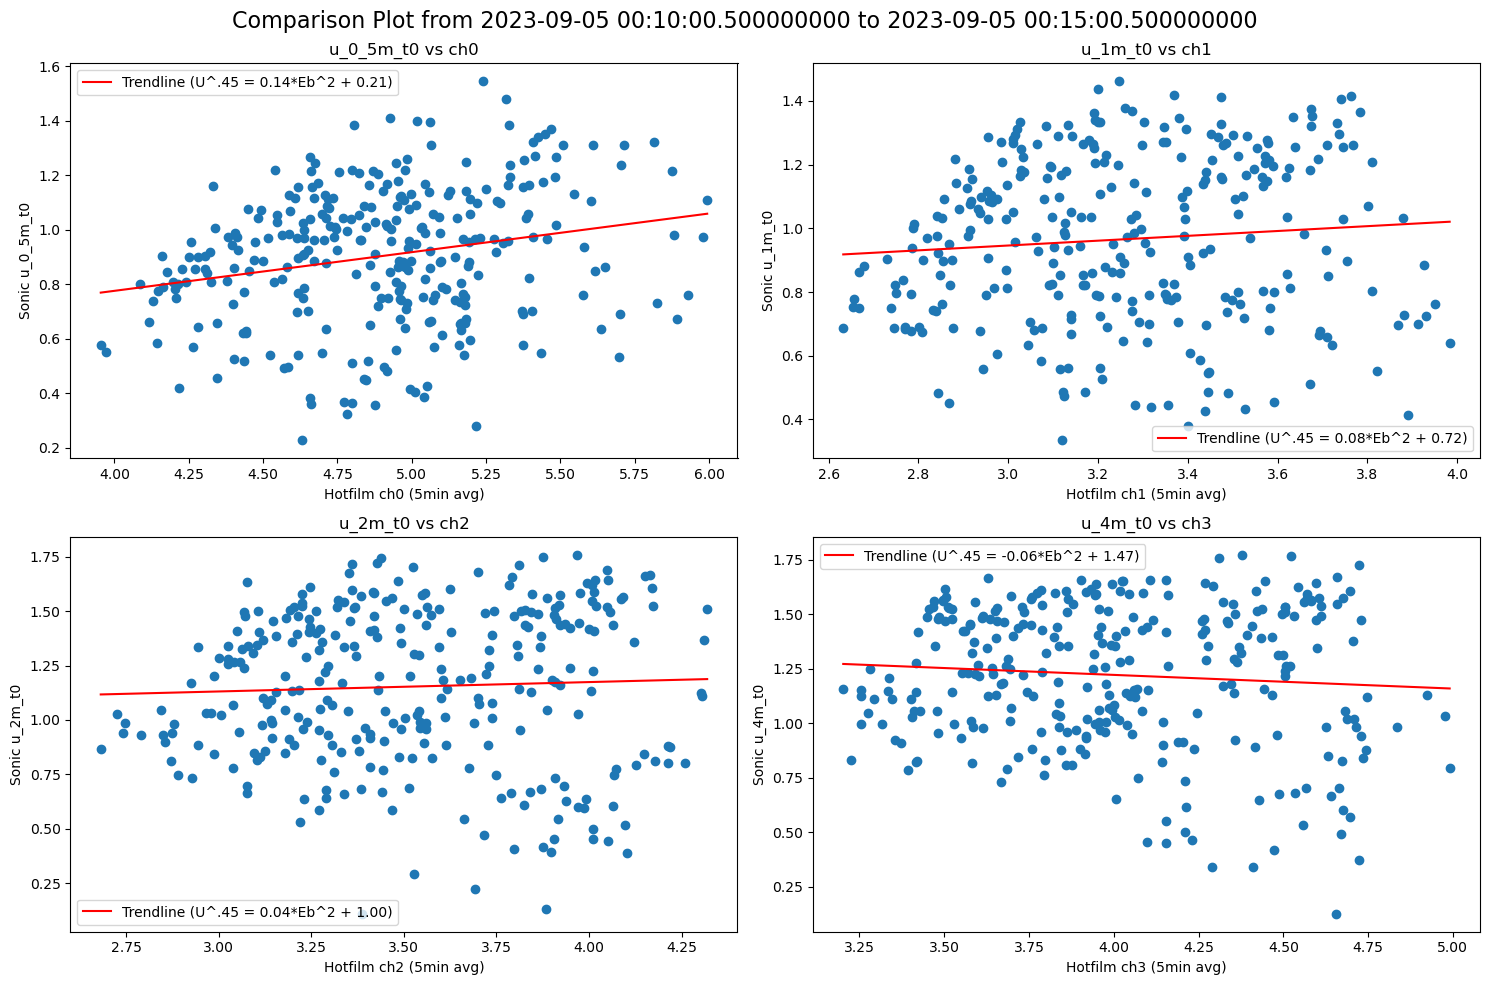

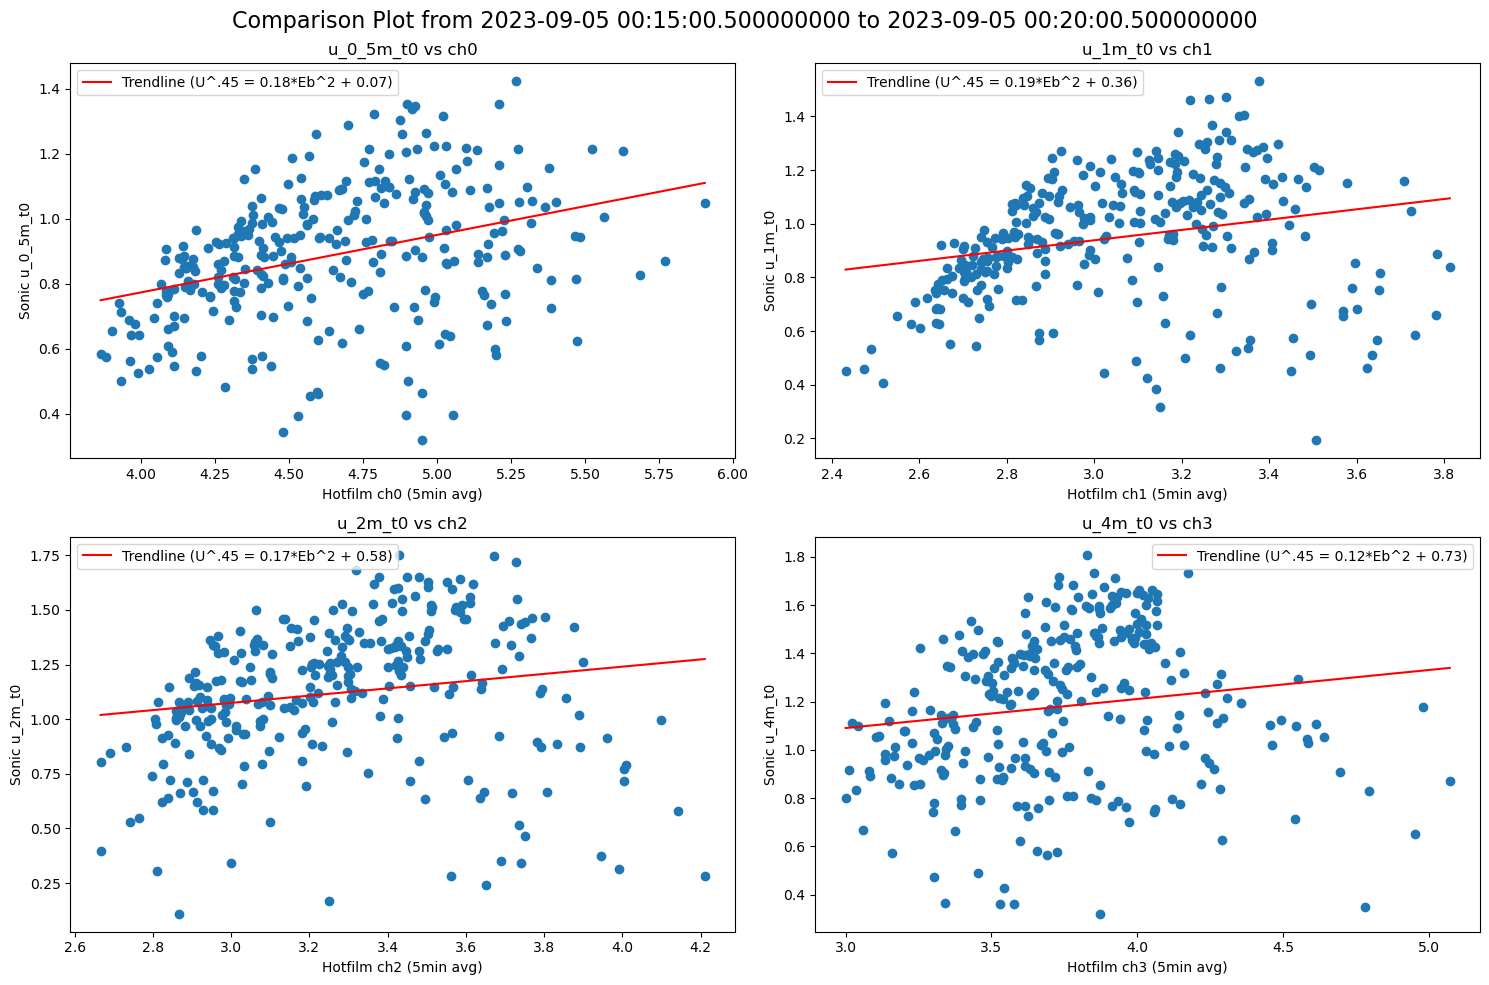

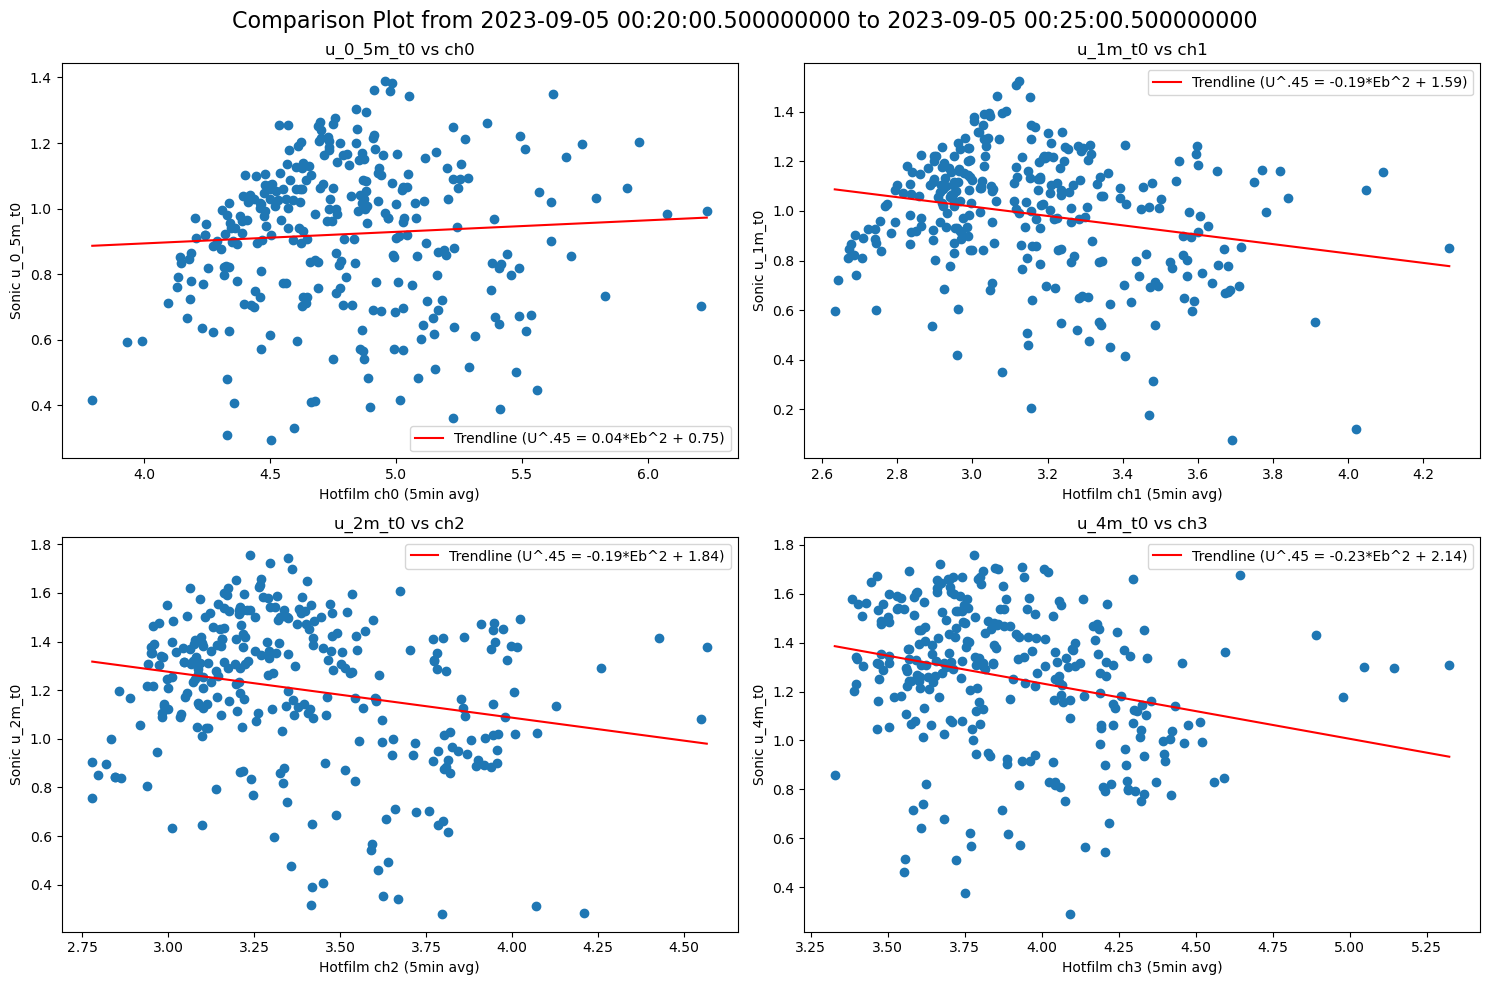

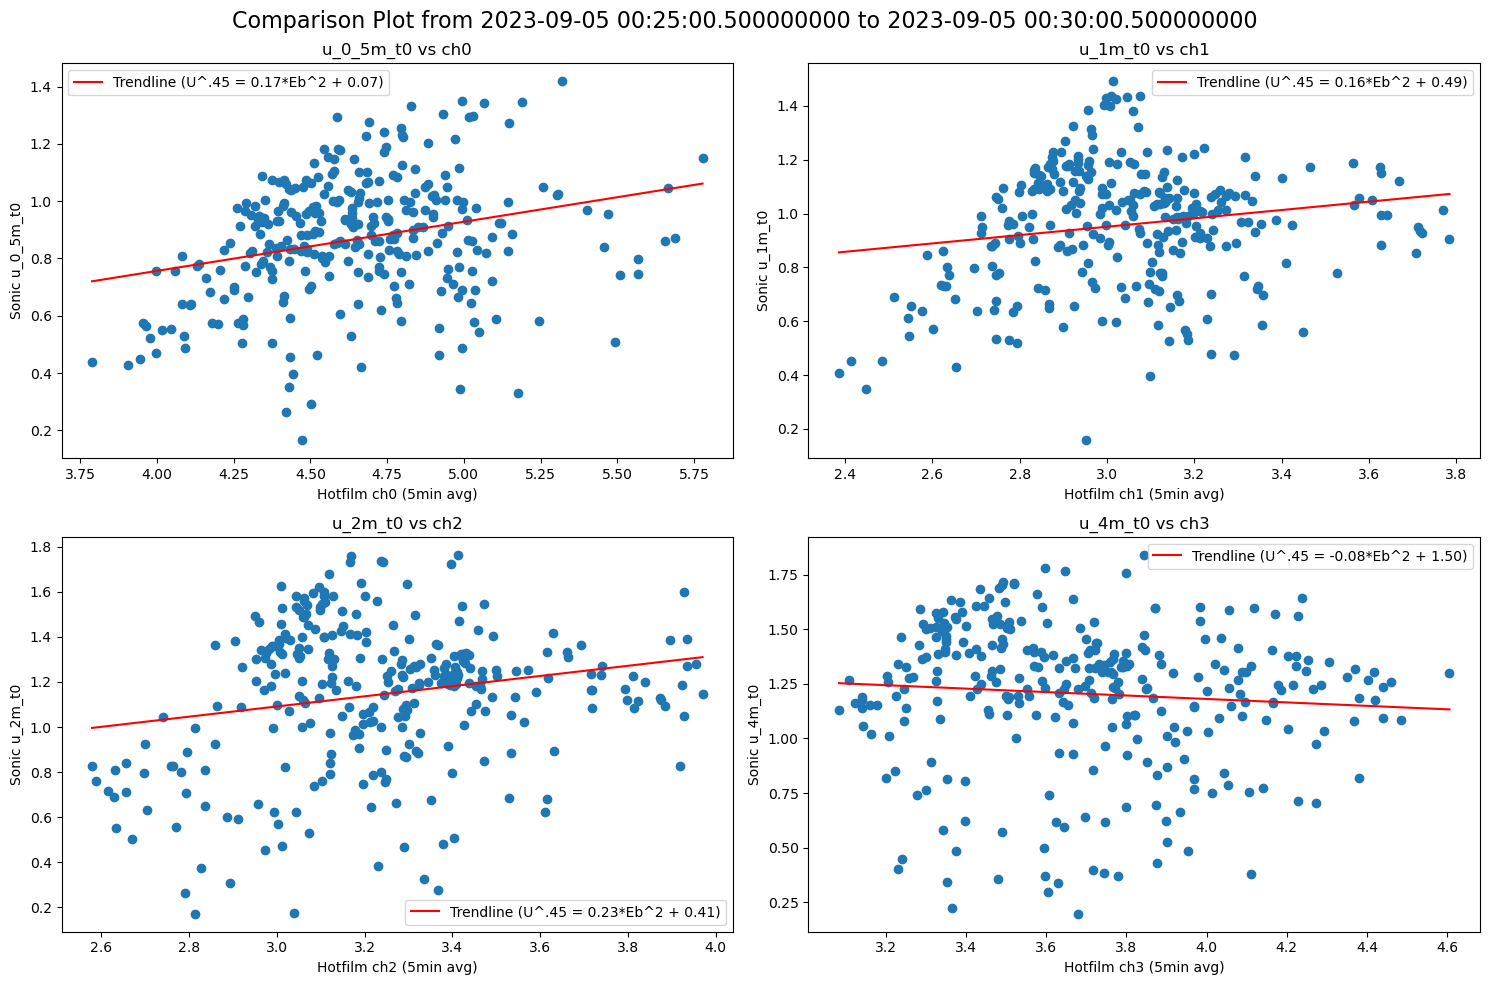

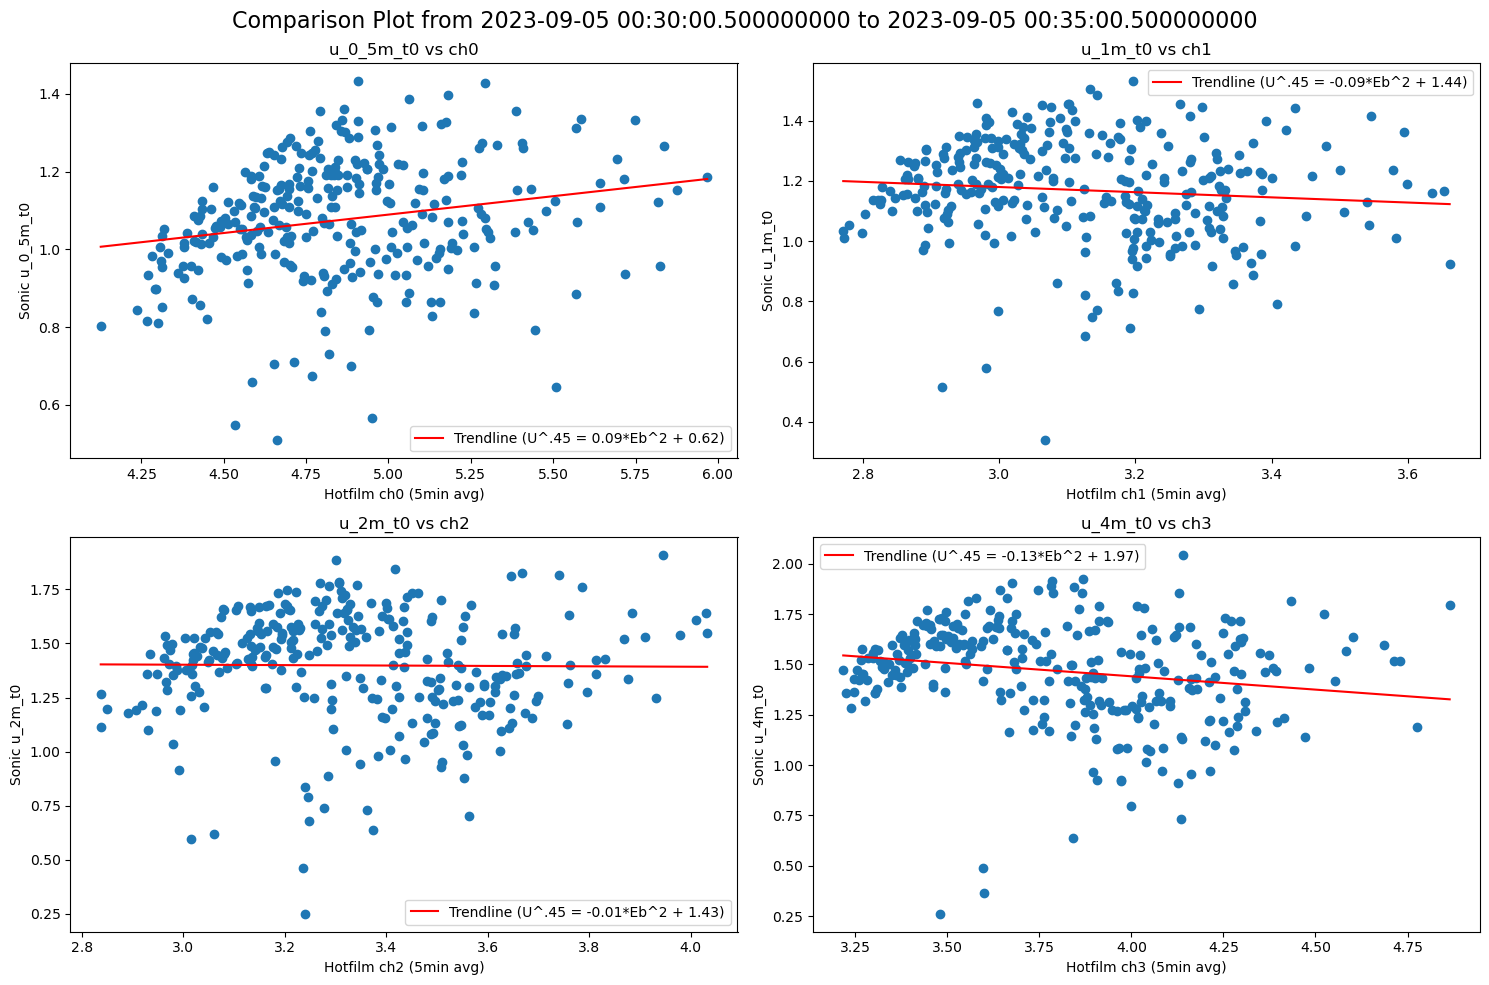

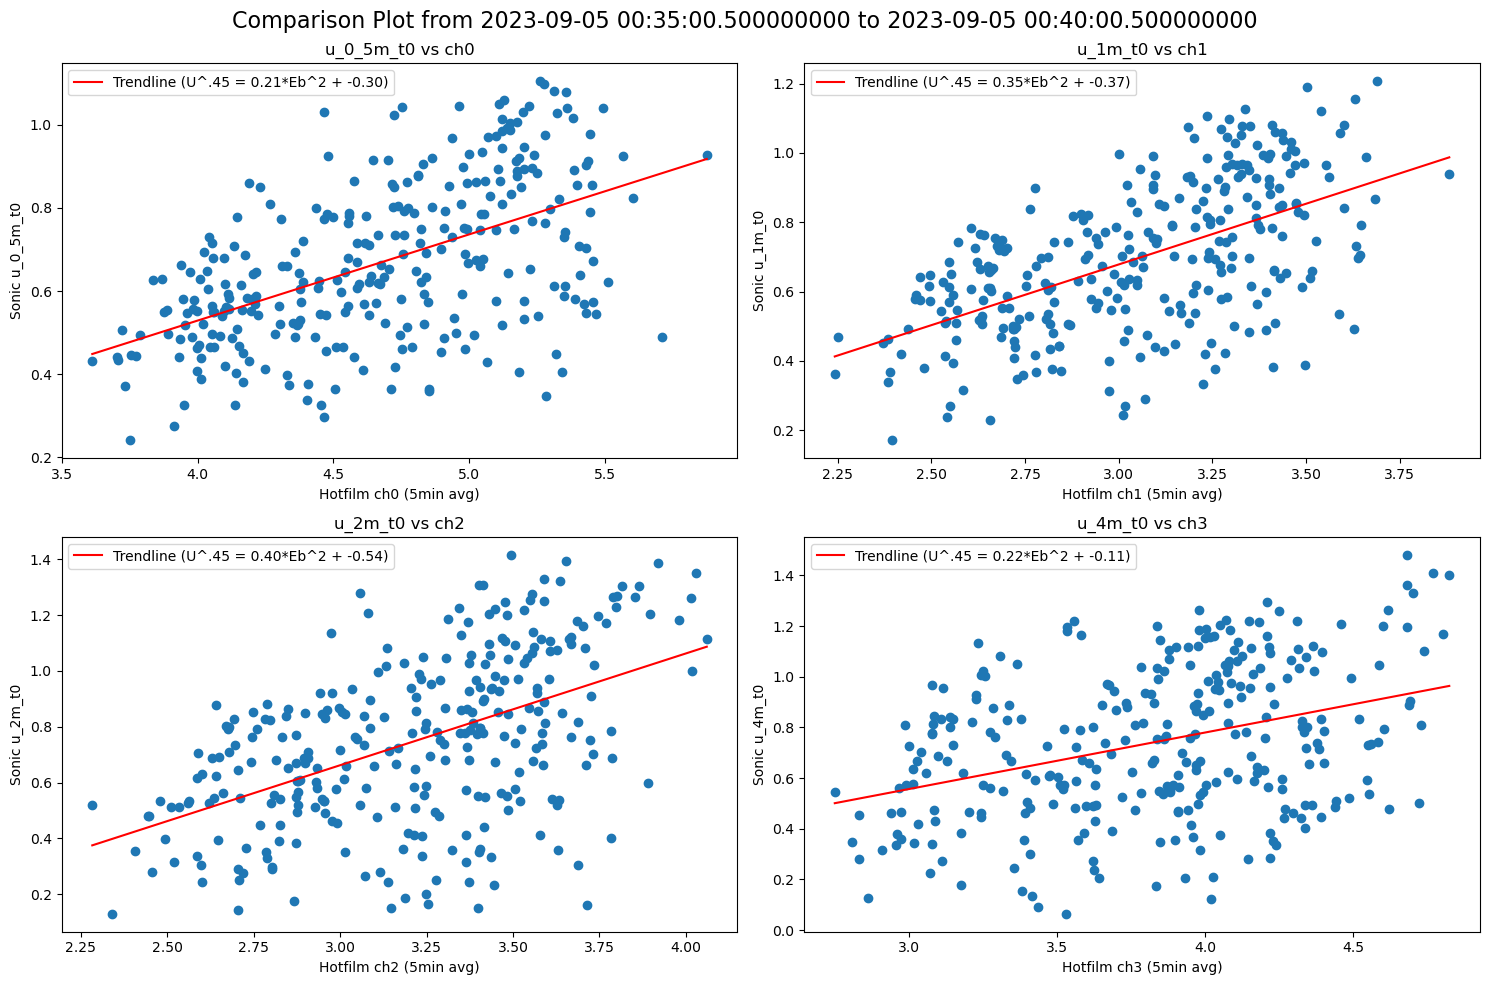

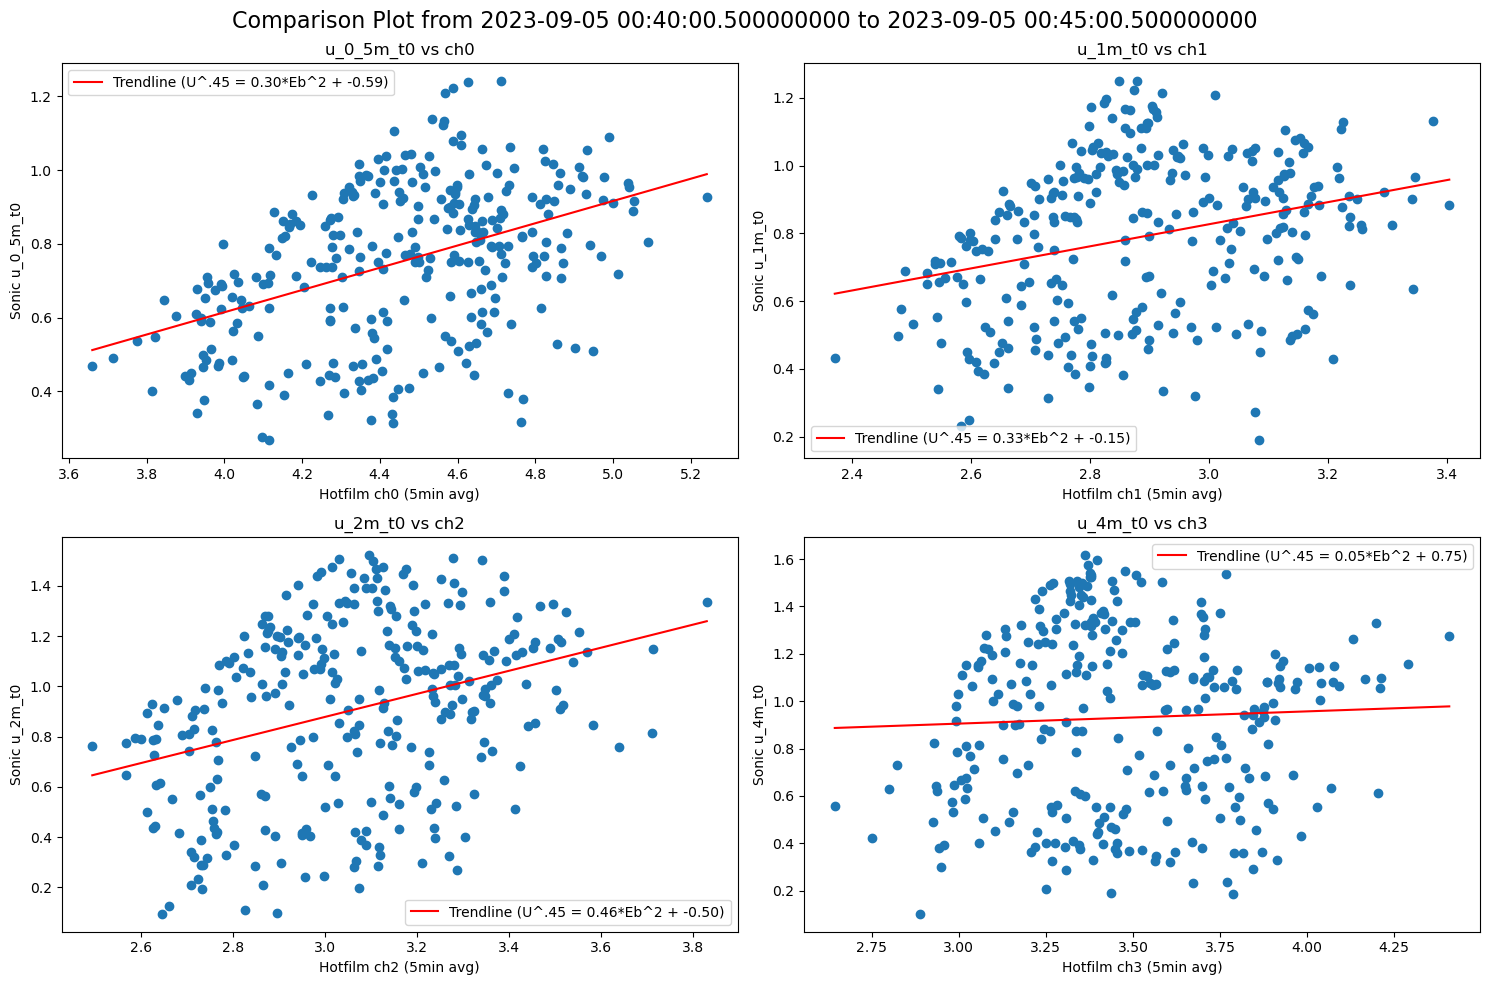

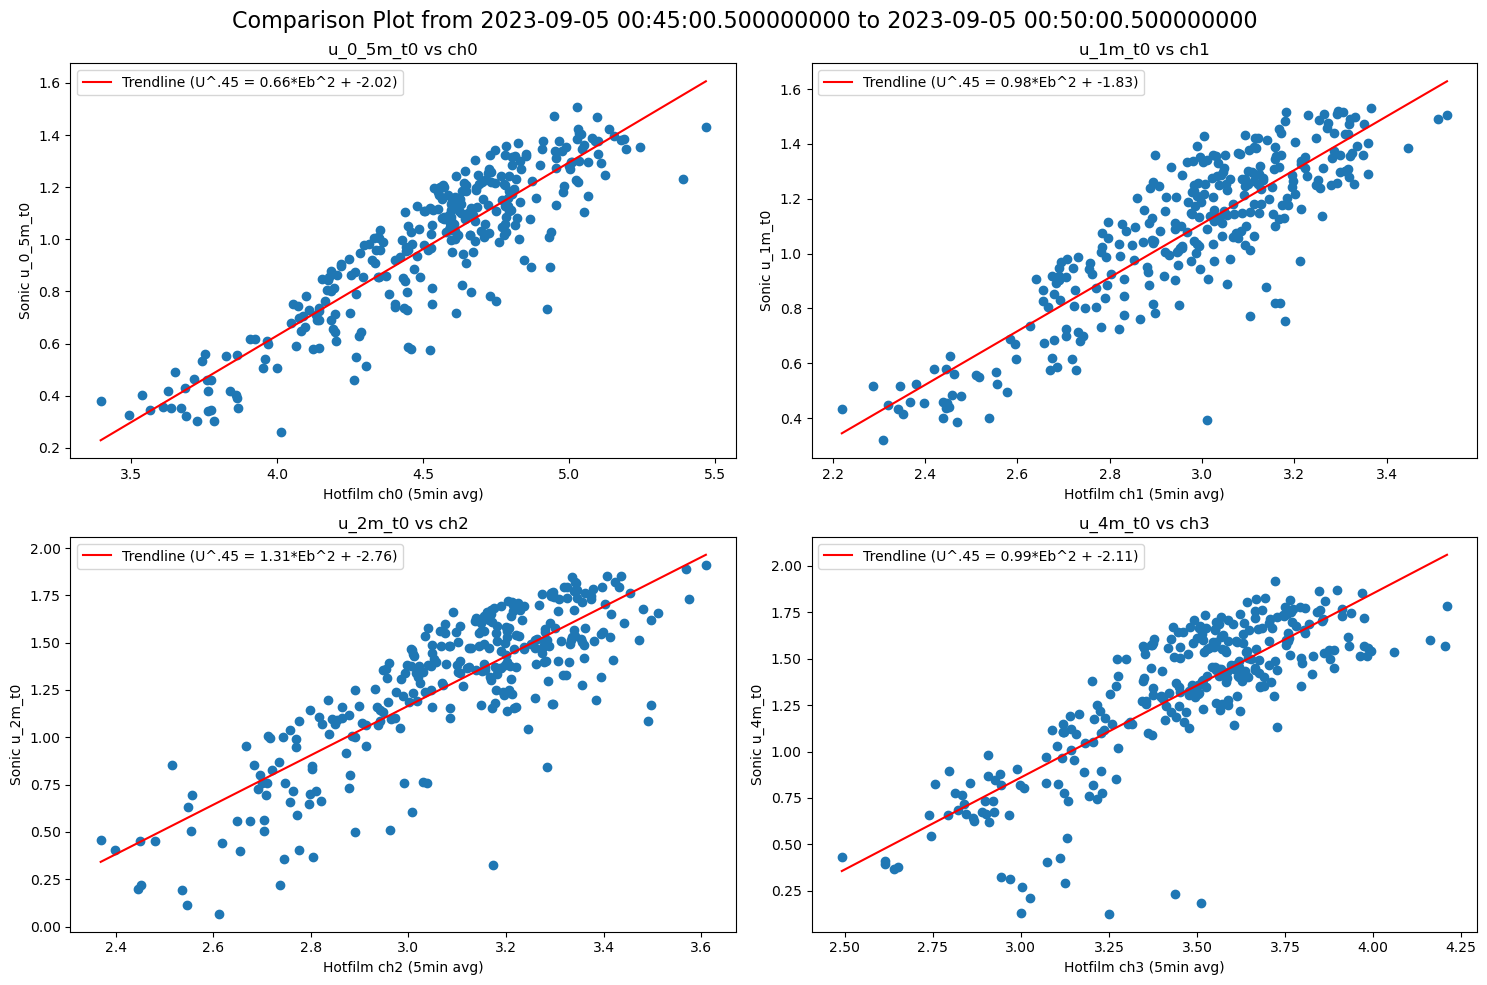

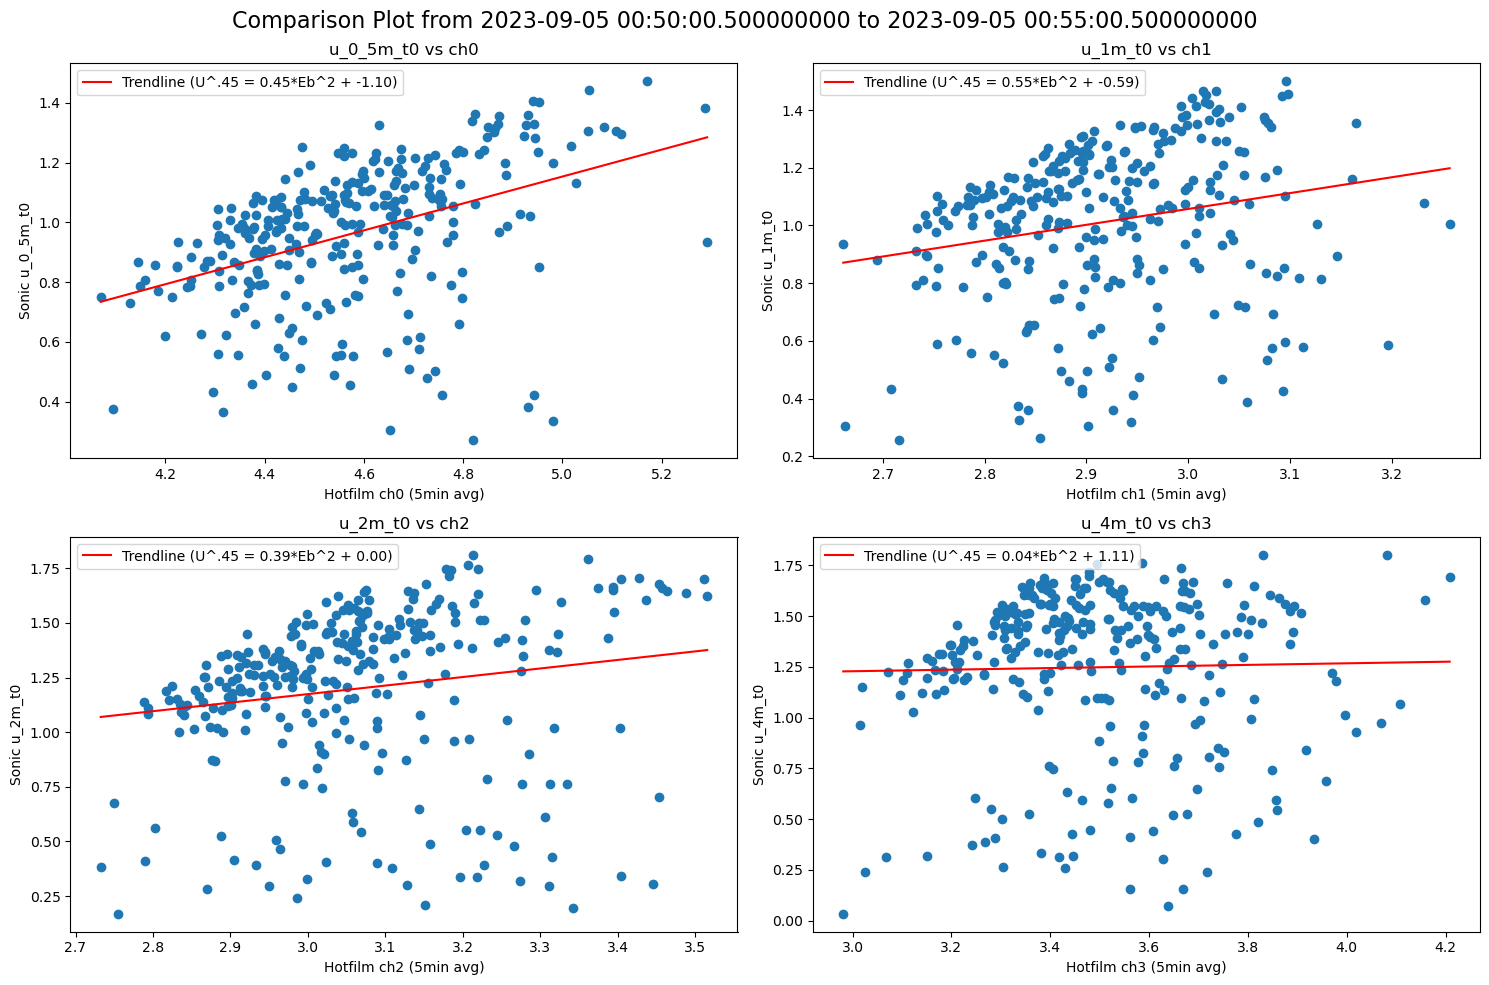

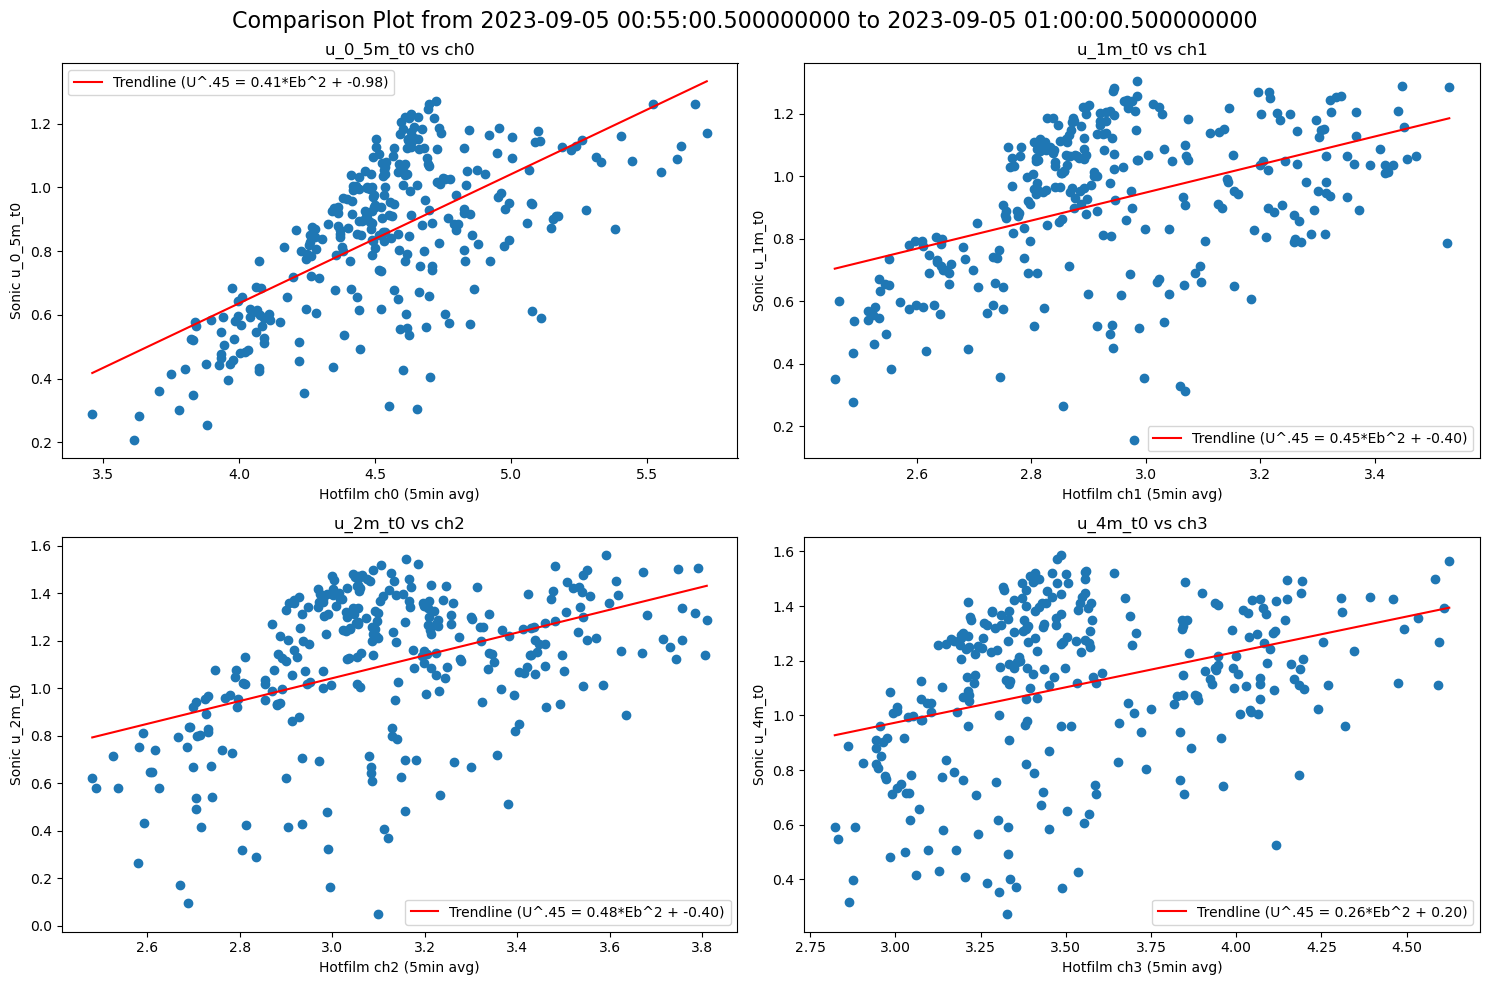

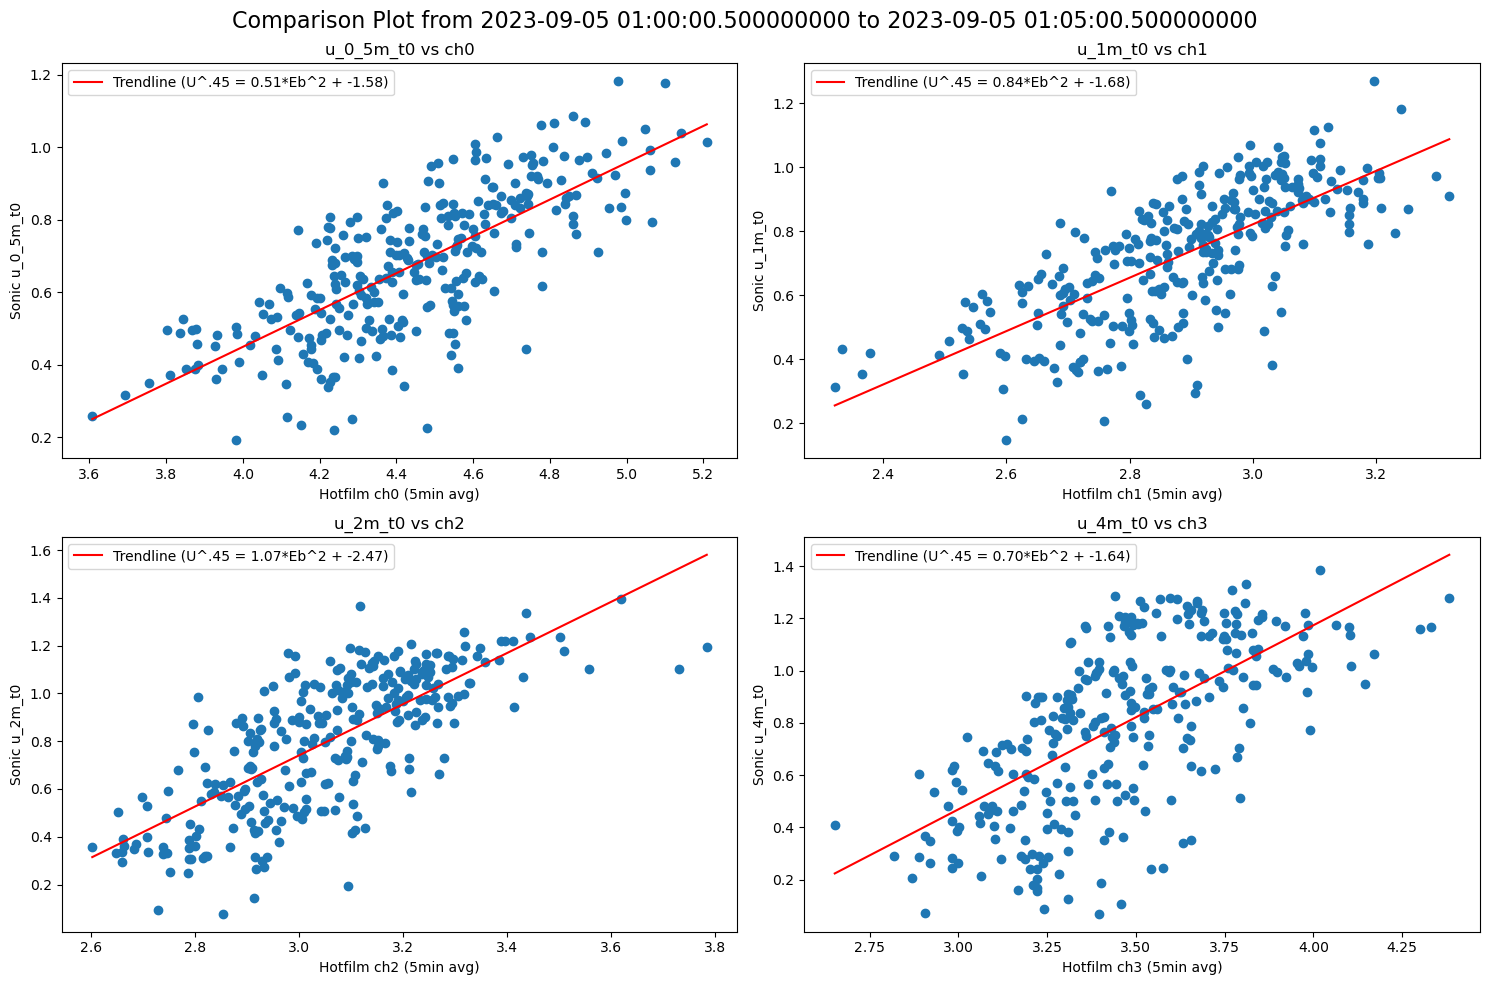

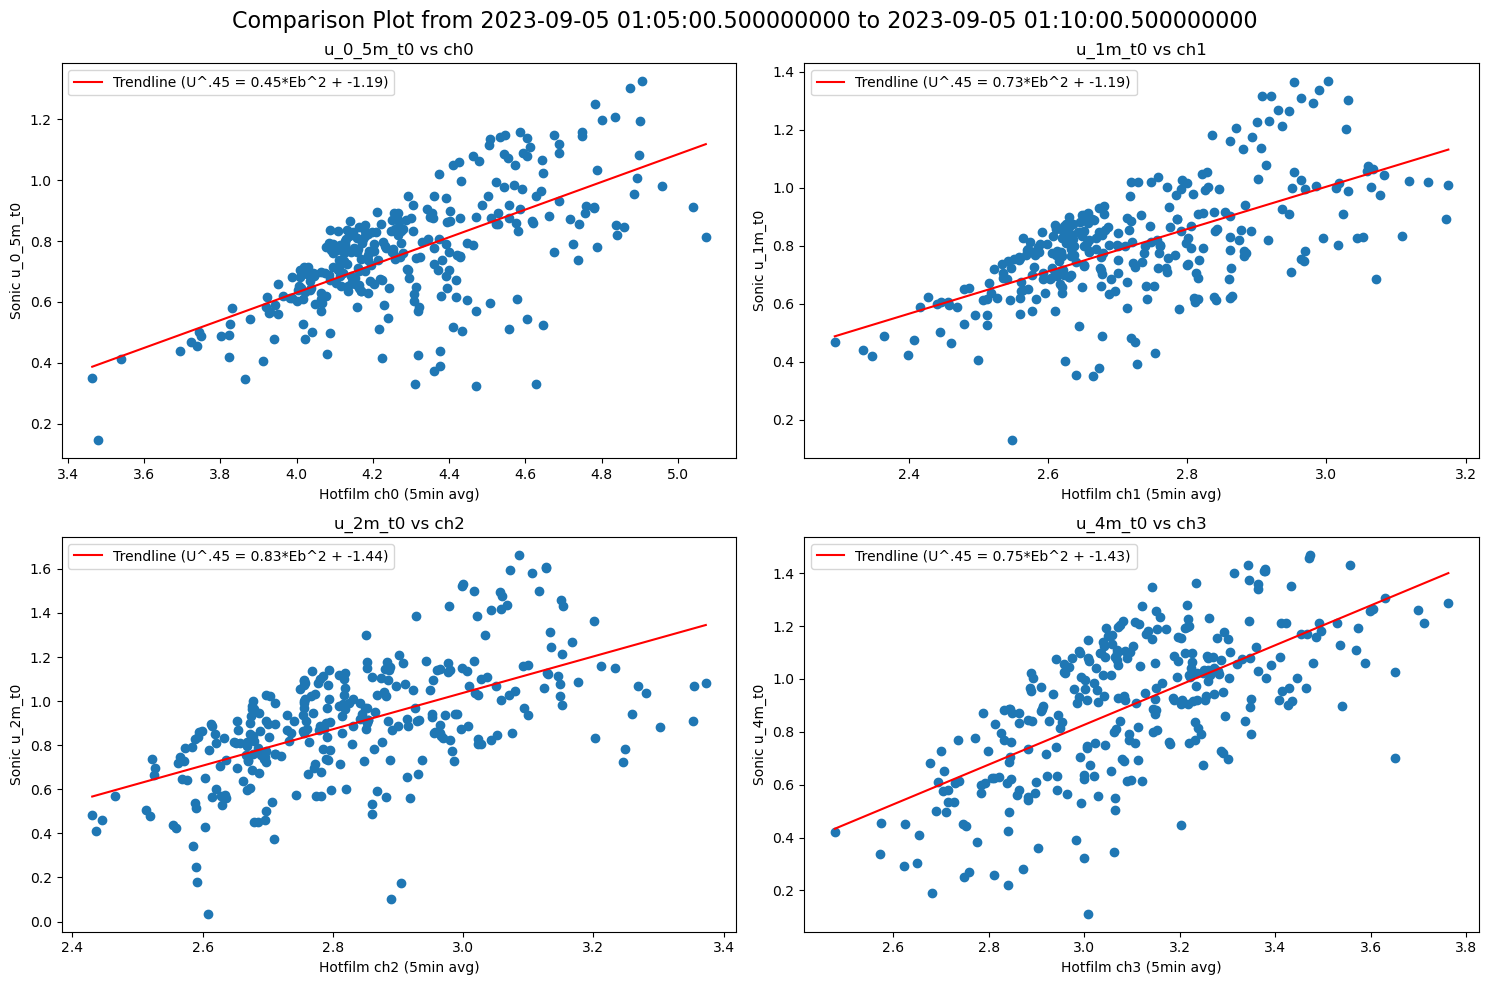

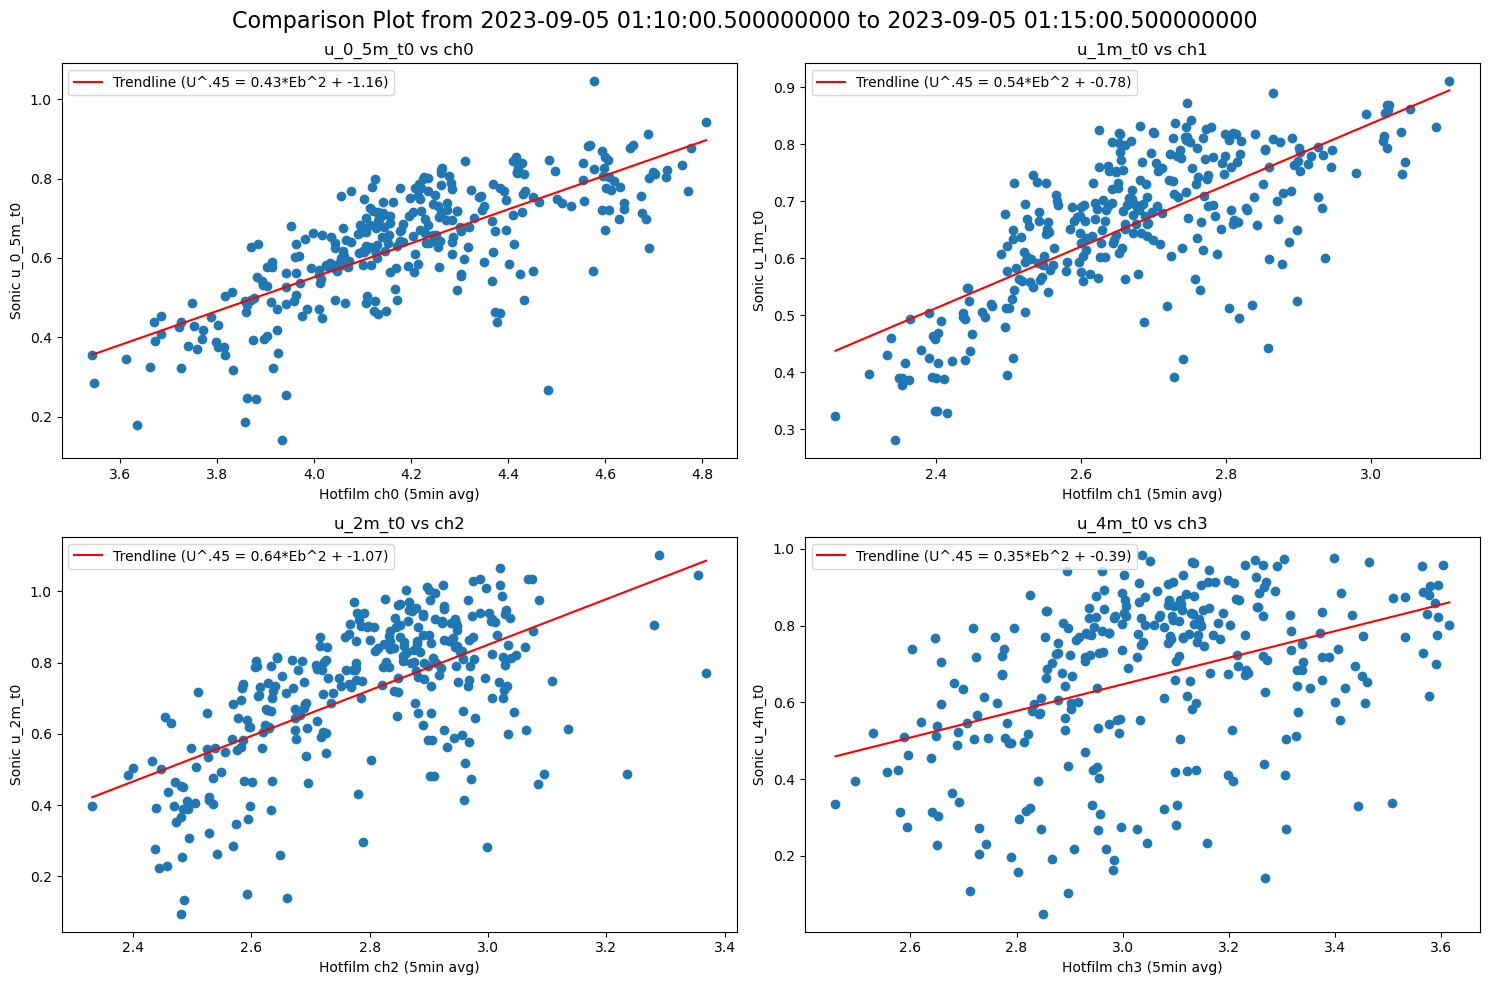

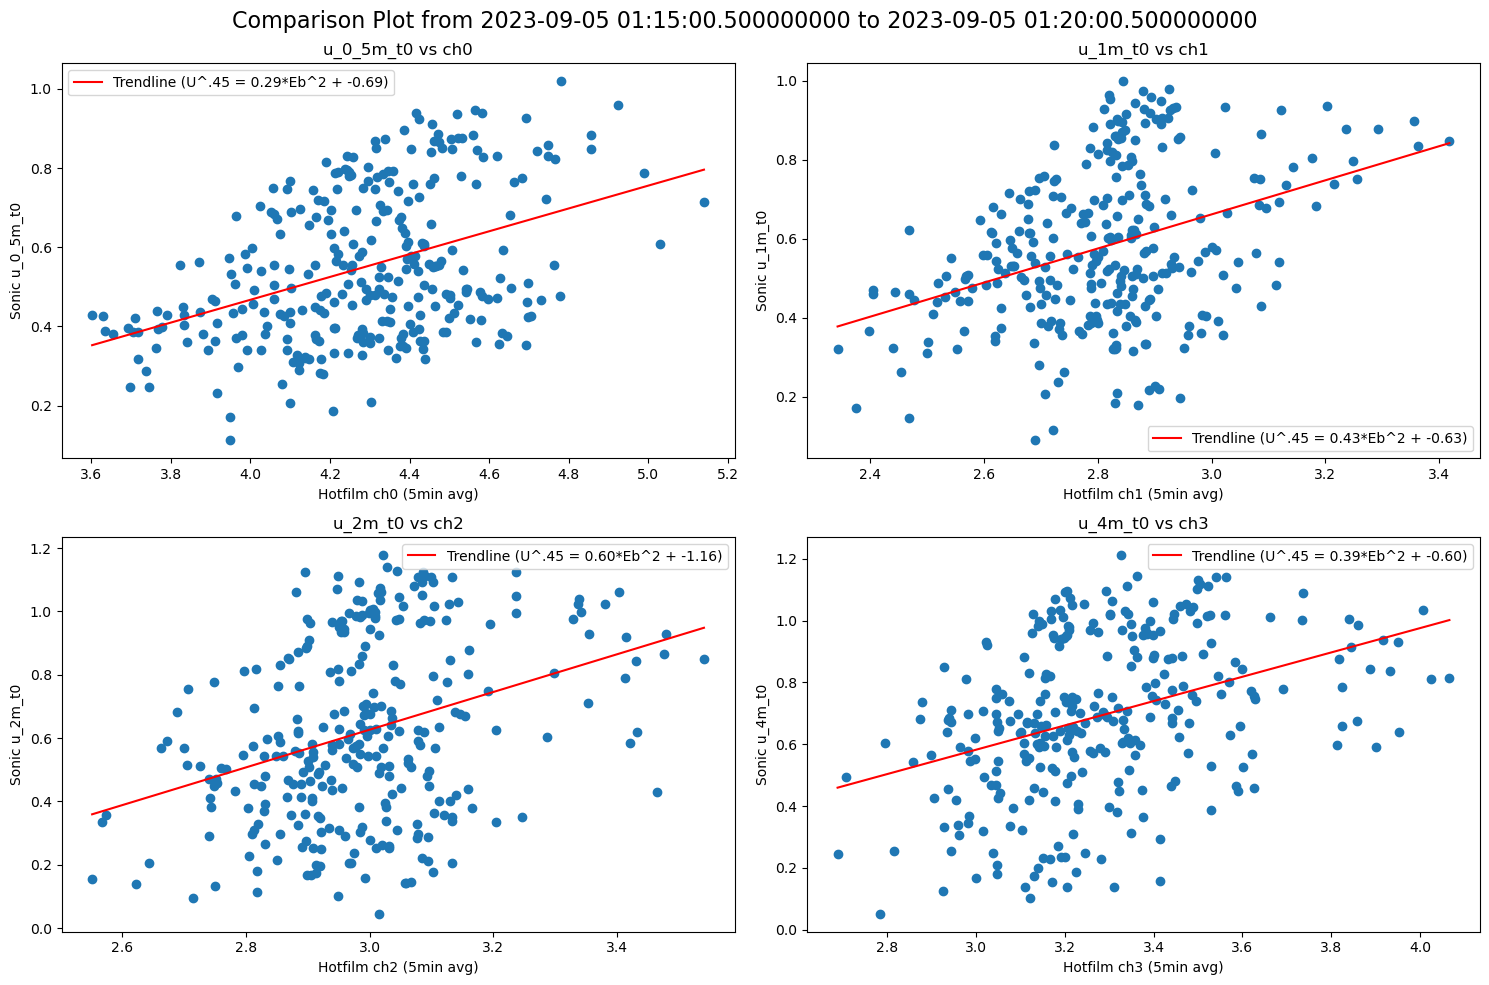

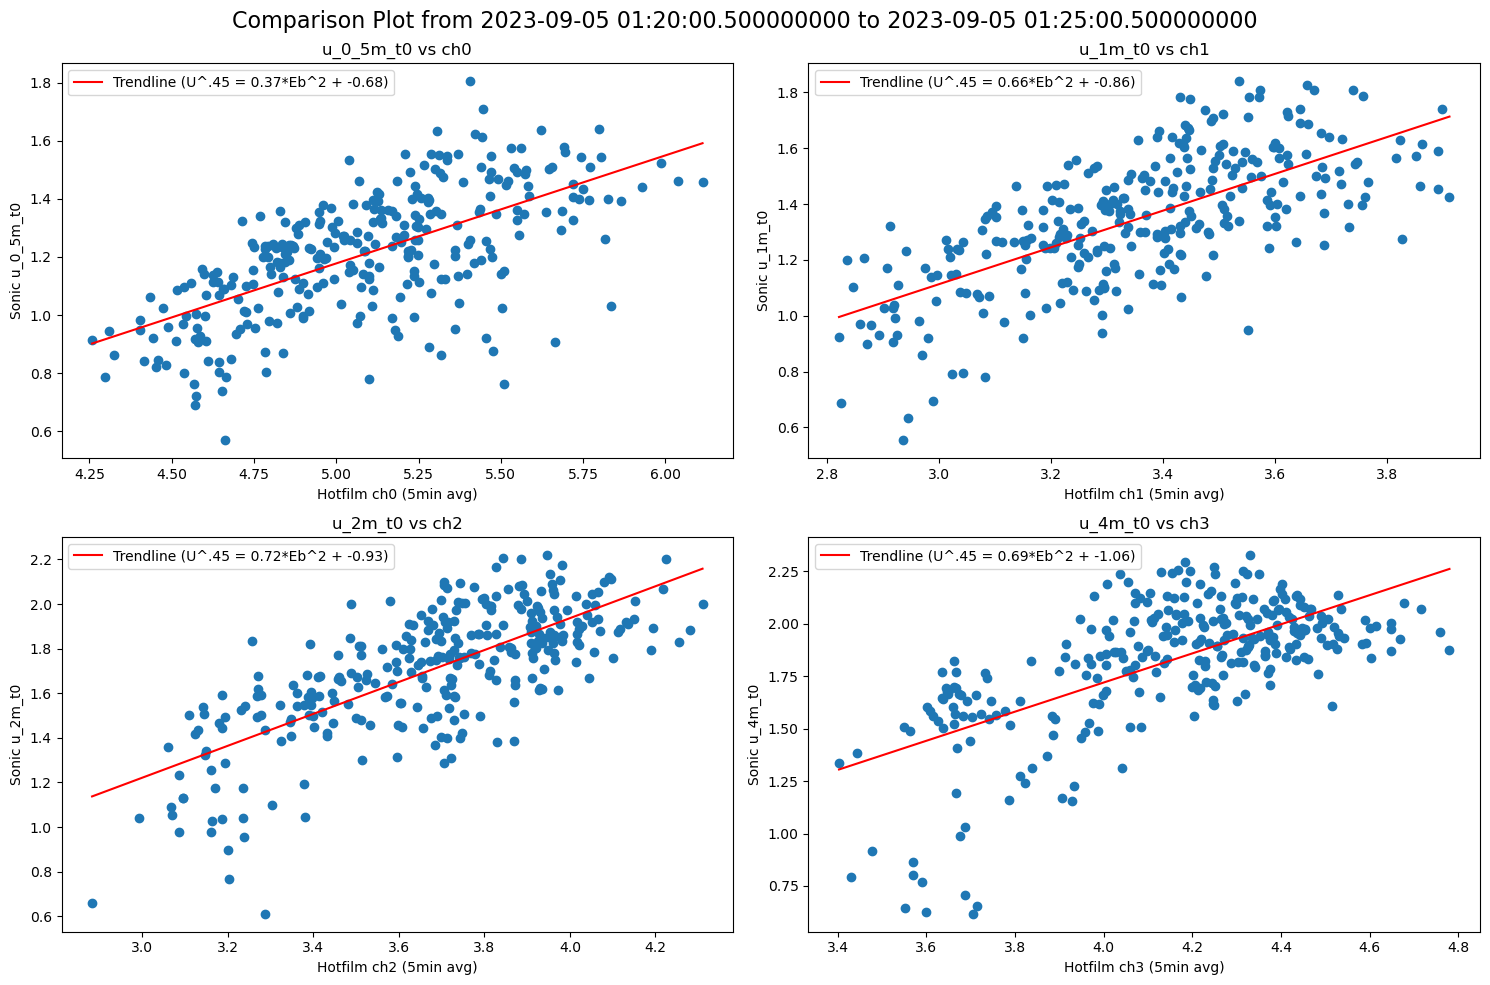

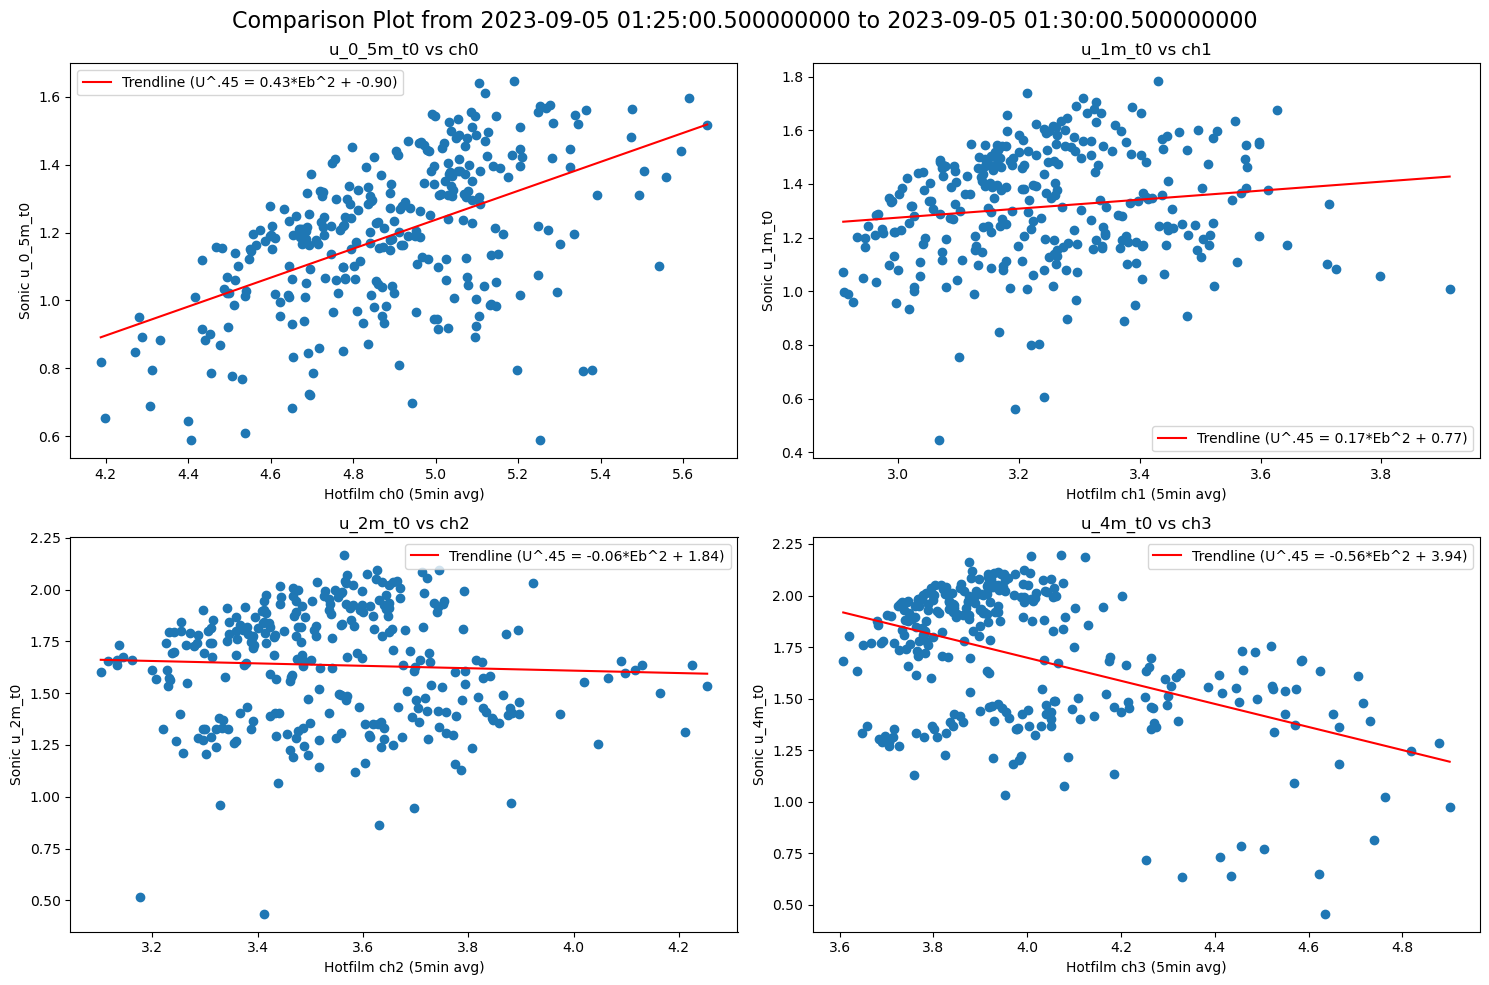

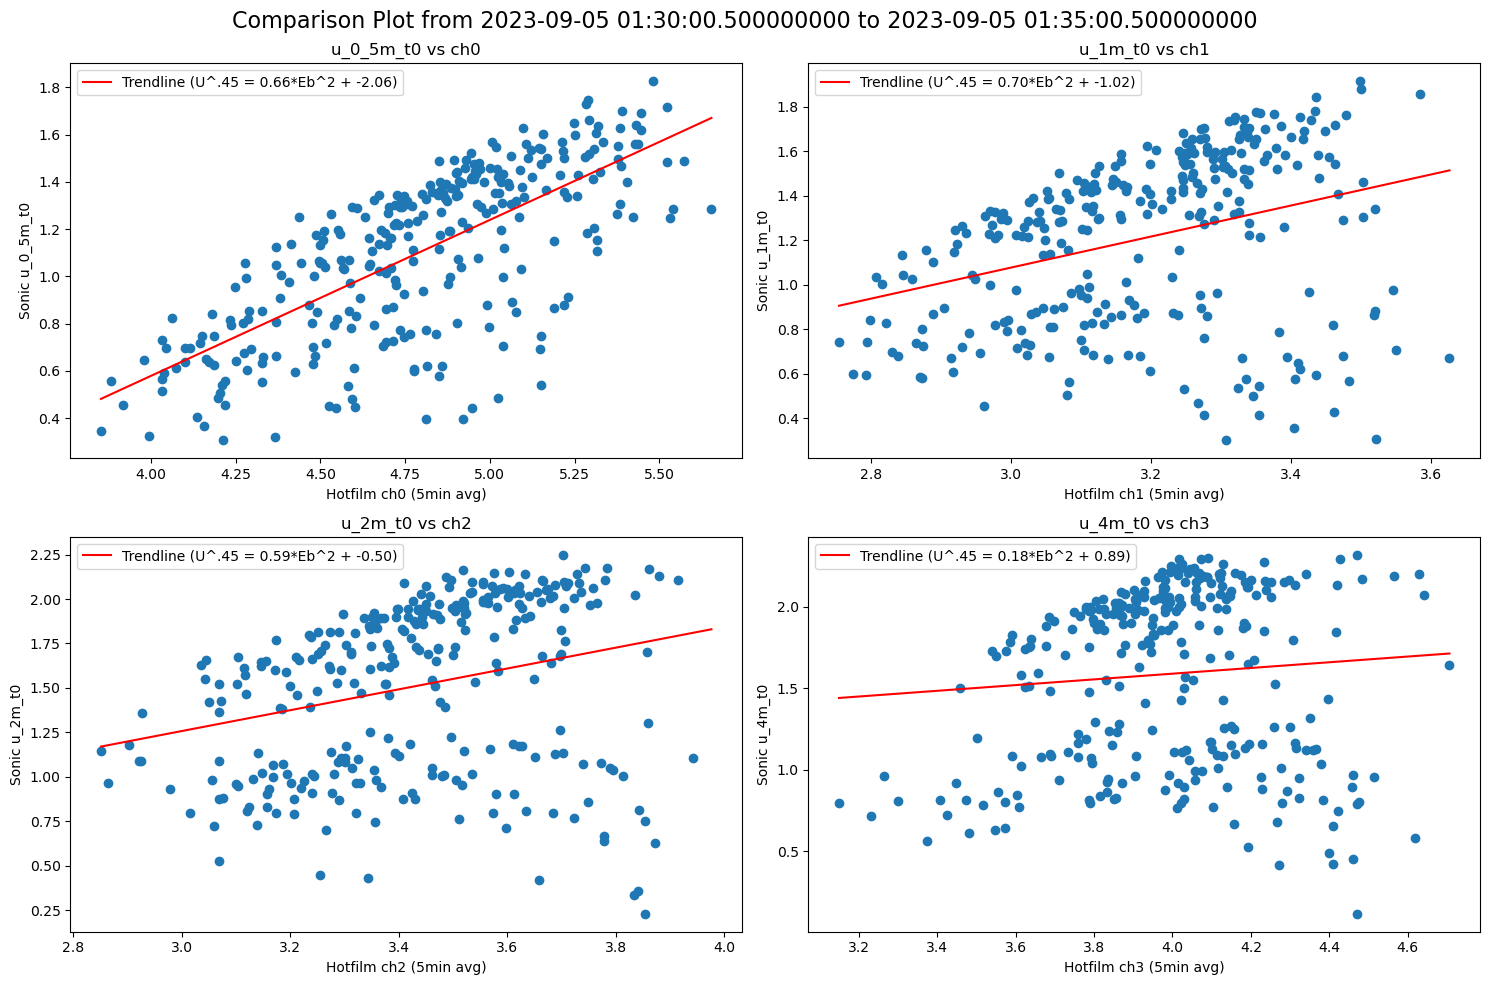

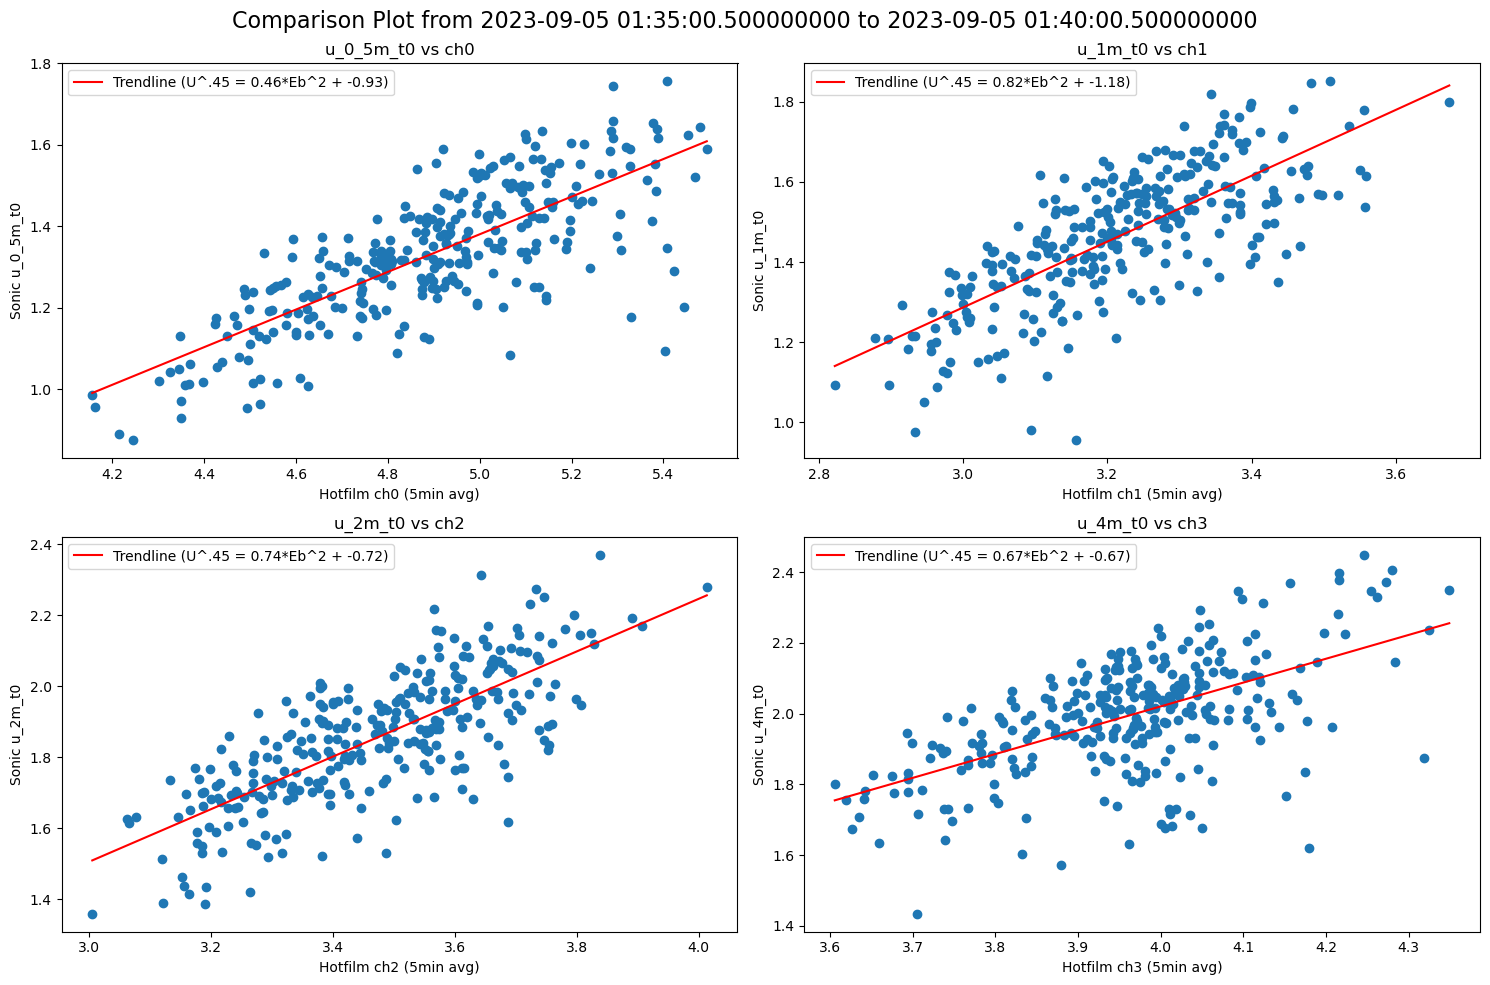

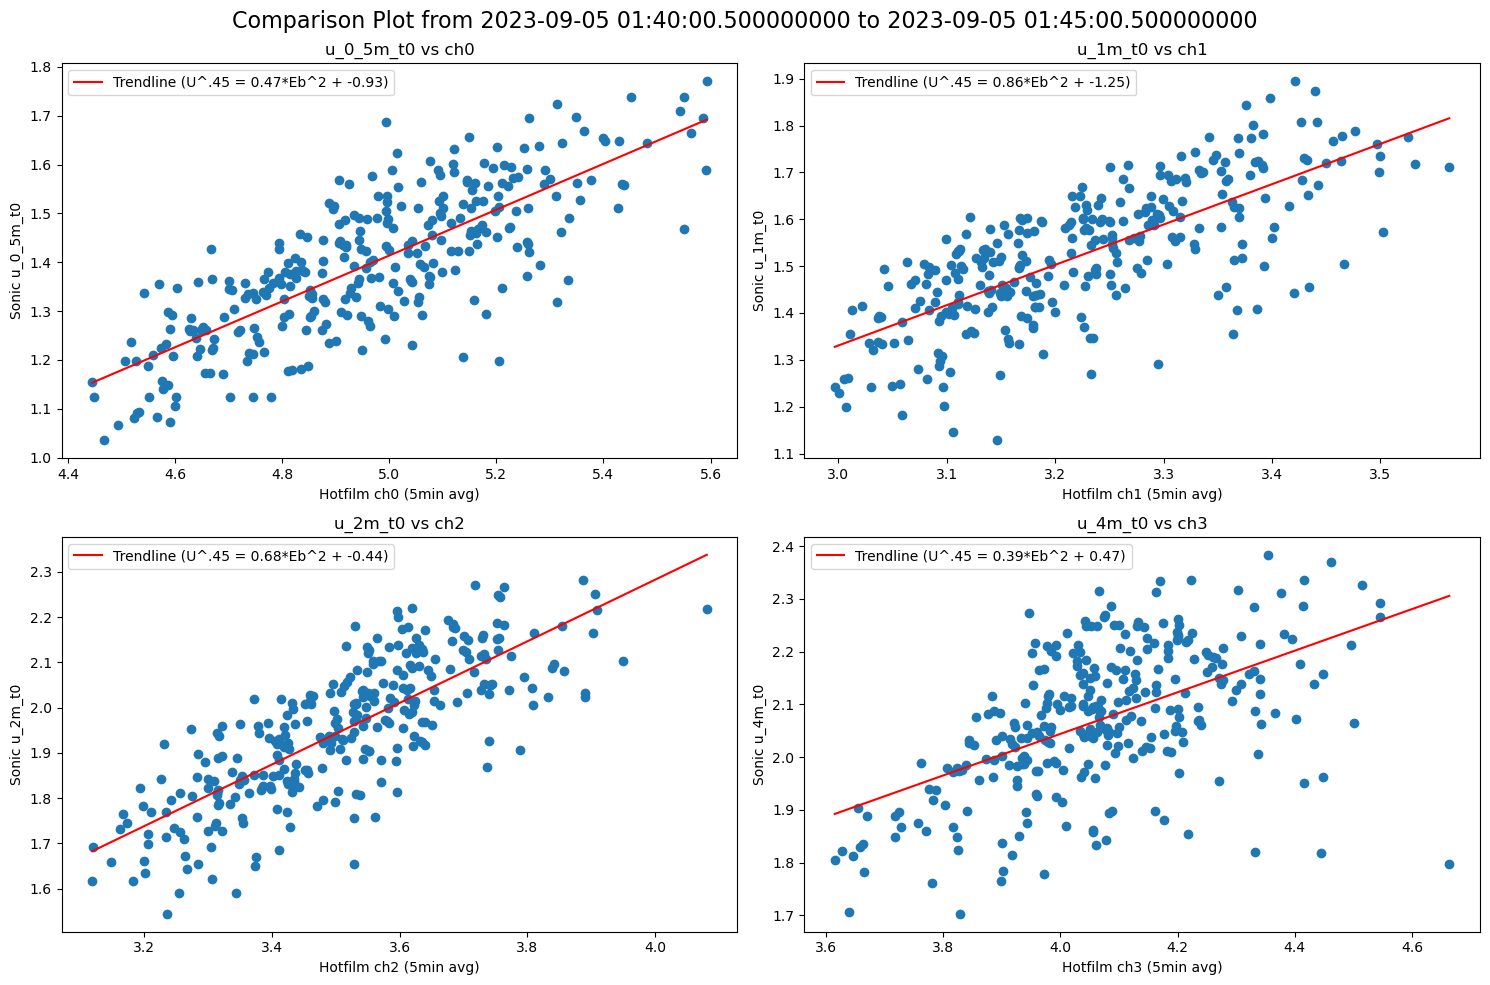

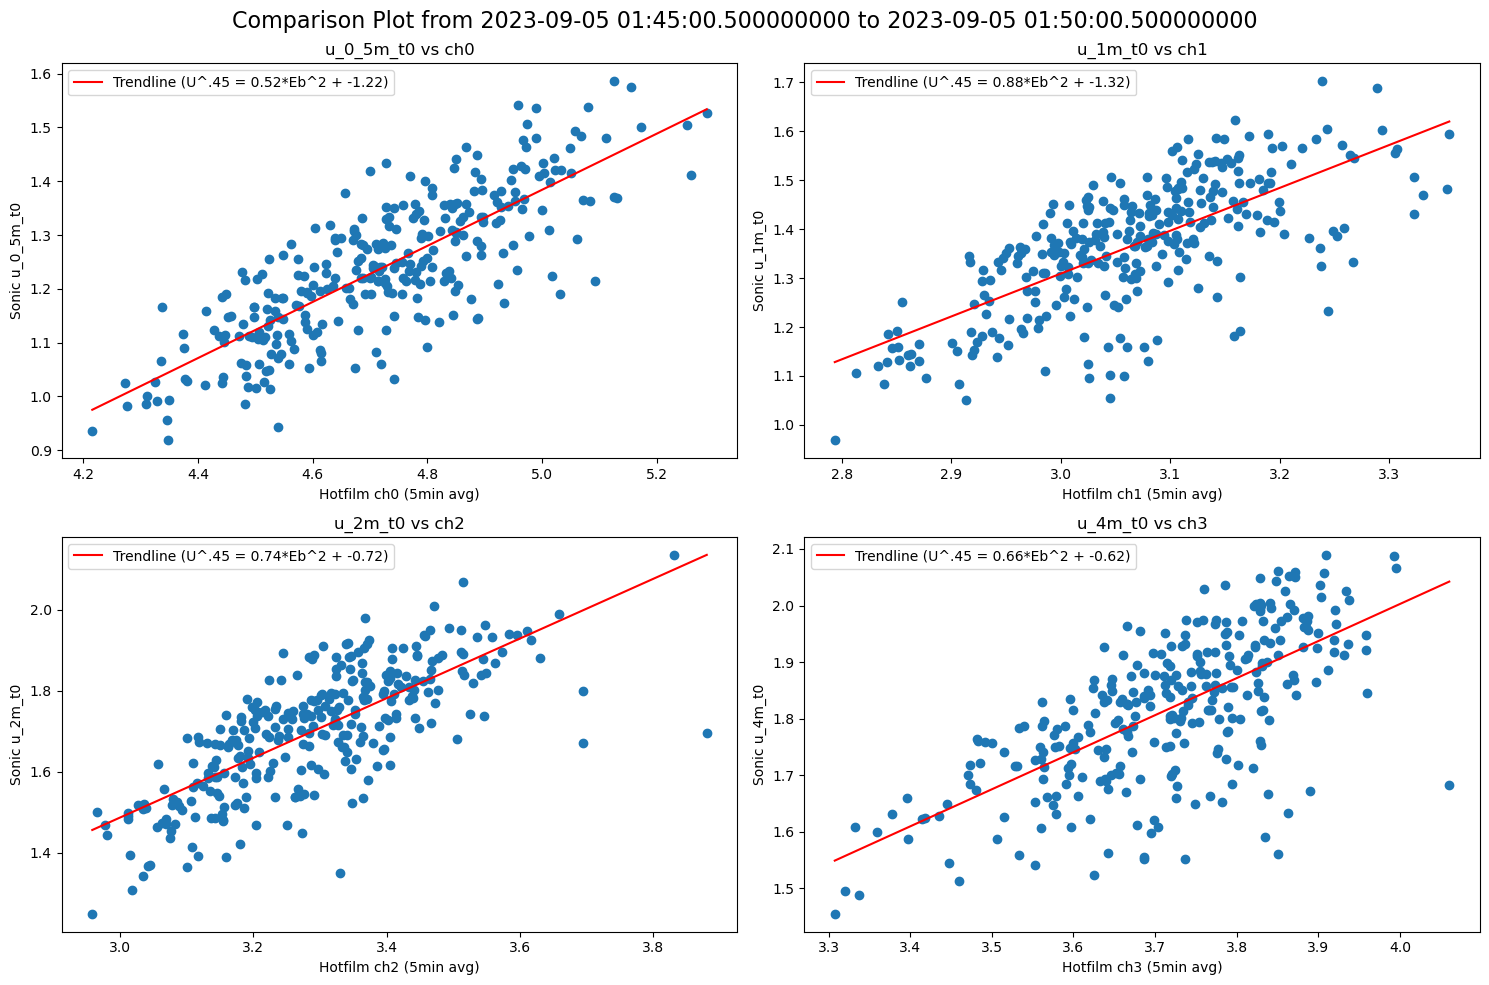

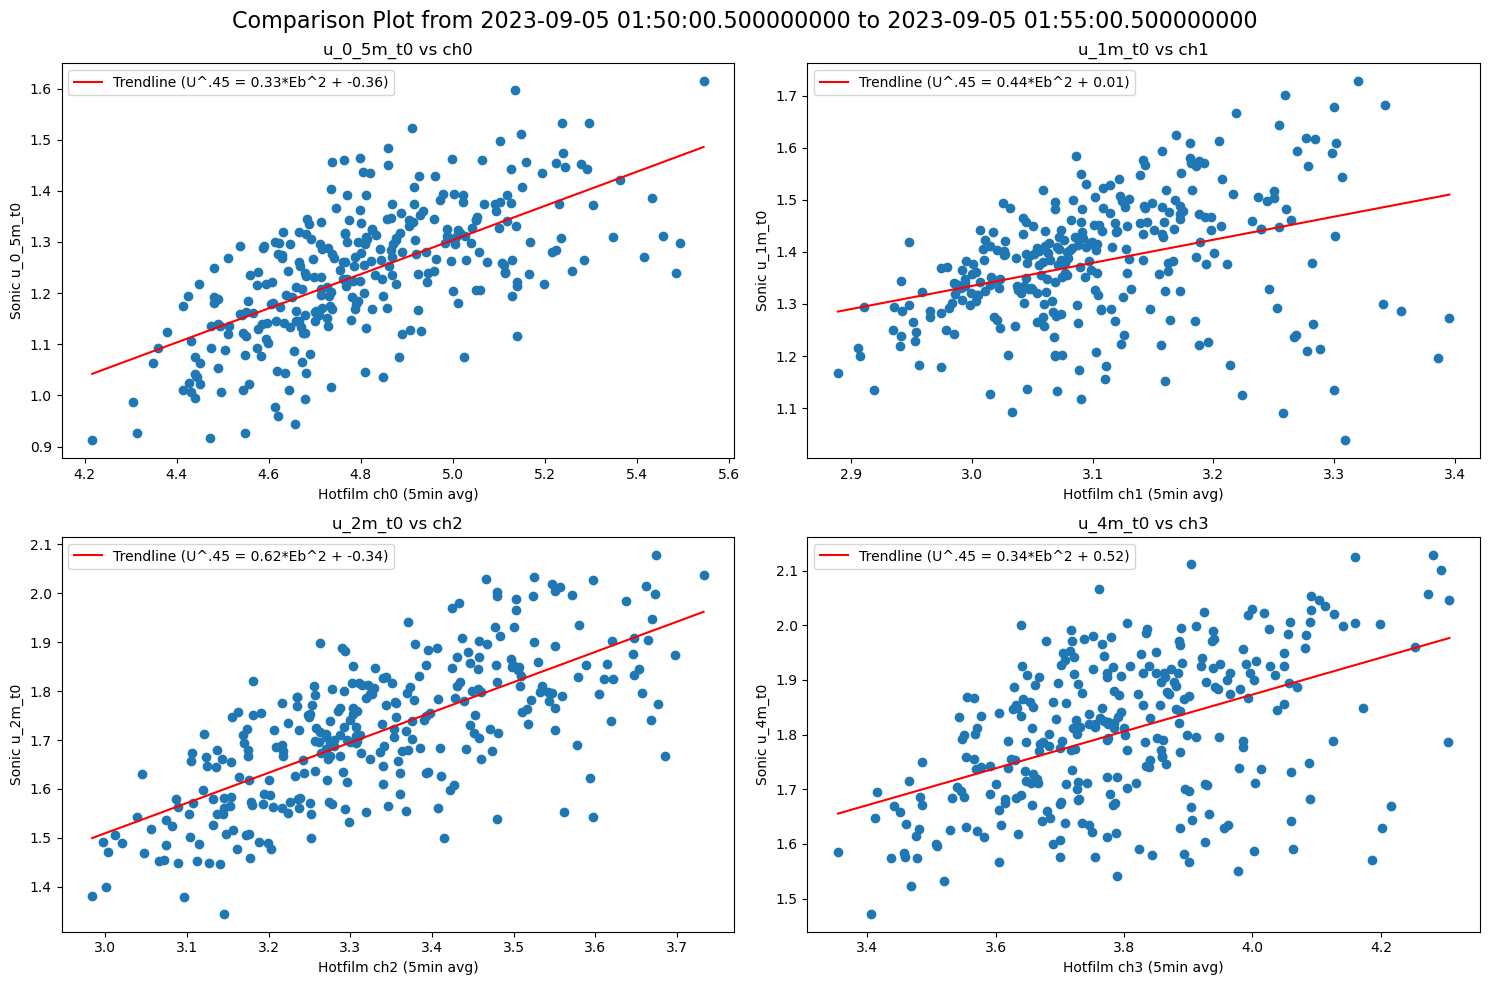

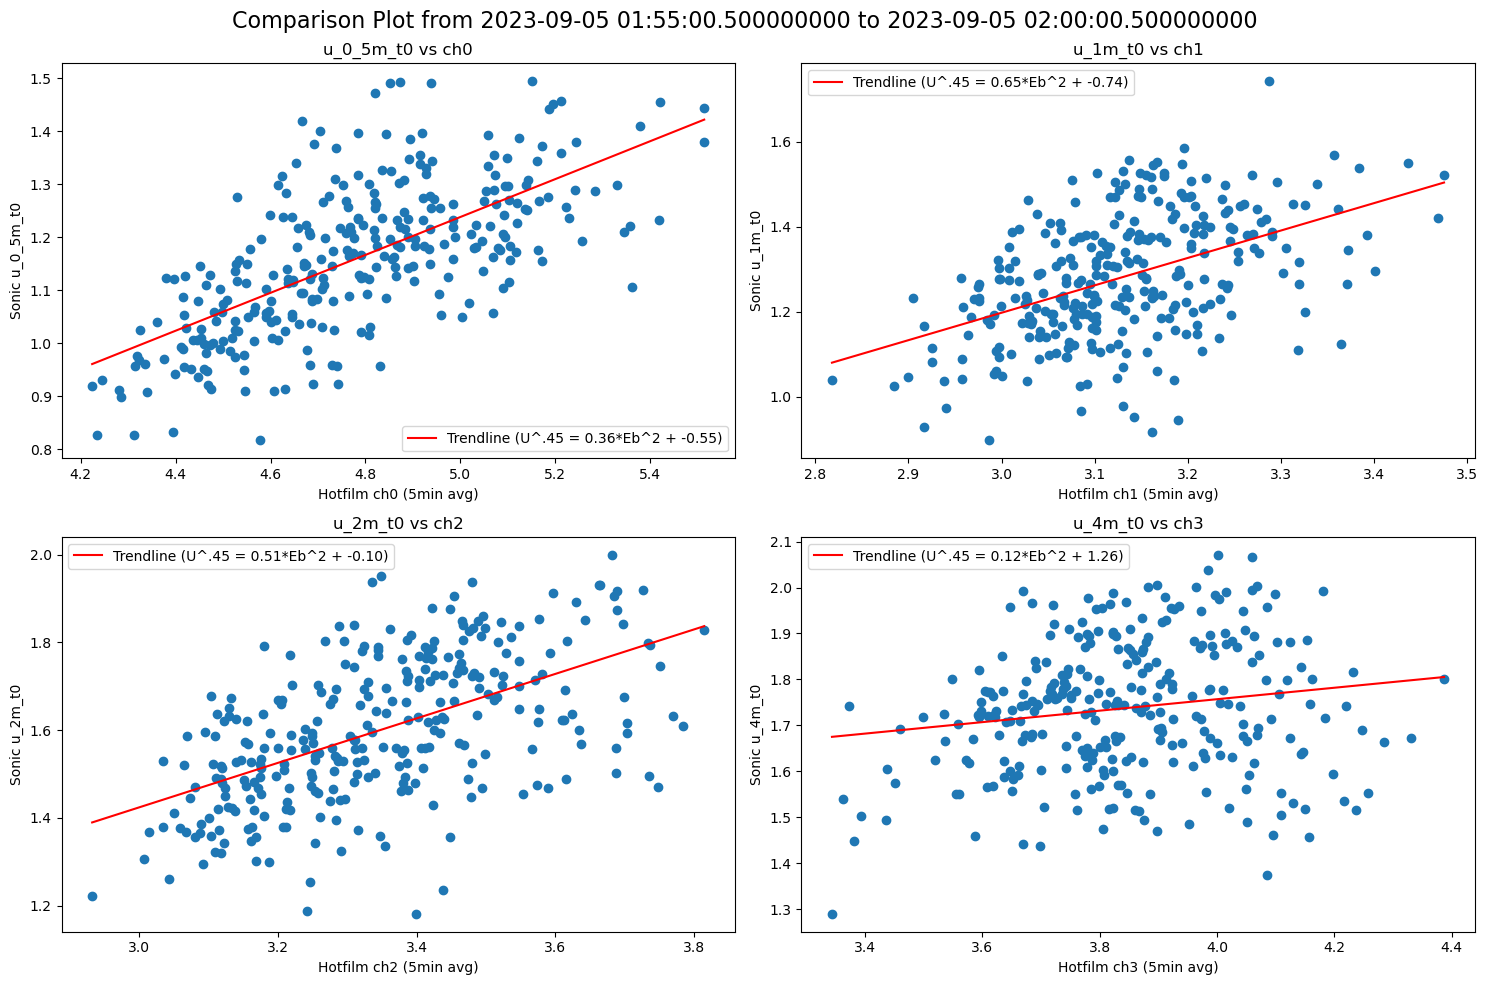

In [8]:
# Initialize a dictionary to store the results
results = {
    'time': [],
    'height': [],
    'a': [],
    'b': [],
    'flag': []
} 

# Iterate for every 5 mins in the hotfilm dataset
for time in np.arange(hotfilm_1s_avg.time[0].values, hotfilm_1s_avg.time[-1].values, np.timedelta64(5, 'm')):
    five_min_sonic = sonic_dataset.sel(time=slice(time, time + np.timedelta64(5, 'm')))
    five_min_hotfilm = hotfilm_1s_avg.sel(time=slice(time, time + np.timedelta64(5, 'm')))

    # Make four-panel comparison plot 
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Scatter plot for u_0_5m_t0 vs ch0
    # Find wind speed using u and w components
    U0 = np.sqrt(five_min_sonic['u_0_5m_t0']**2 + five_min_sonic['w_0_5m_t0']**2)

    # Call scatter function
    a0, b0, flag0 = plot_scatter_and_curve(axs[0, 0], U0, five_min_hotfilm['ch0'],
                                    'u_0_5m_t0 vs ch0', 'Hotfilm ch0 (5min avg)', 'Sonic u_0_5m_t0')
    results['time'].append(time)
    results['height'].append('0.5m')
    results['a'].append(a0)
    results['b'].append(b0)
    results['flag'].append(flag0)

    # Scatter plot for u_1m_t0 vs ch1
    # Find wind speed using u and w components
    U1 = np.sqrt(five_min_sonic['u_1m_t0']**2 + five_min_sonic['w_1m_t0']**2)
    
    # Call scatter function
    a1, b1, flag1 = plot_scatter_and_curve(axs[0, 1], U1, five_min_hotfilm['ch1'],
                                    'u_1m_t0 vs ch1', 'Hotfilm ch1 (5min avg)', 'Sonic u_1m_t0')
    results['time'].append(time)
    results['height'].append('1m')
    results['a'].append(a1)
    results['b'].append(b1)
    results['flag'].append(flag1)

    # Scatter plot for u_2m_t0 vs ch2
    # Find wind speed using u and w components
    U2 = np.sqrt(five_min_sonic['u_2m_t0']**2 + five_min_sonic['u_2m_t0']**2)
    
    # Call scatter function
    a2, b2, flag2 = plot_scatter_and_curve(axs[1, 0], U2, five_min_hotfilm['ch2'],
                                    'u_2m_t0 vs ch2', 'Hotfilm ch2 (5min avg)', 'Sonic u_2m_t0')
    results['time'].append(time)
    results['height'].append('2m')
    results['a'].append(a2)
    results['b'].append(b2)
    results['flag'].append(flag2)

    # Scatter plot for u_4m_t0 vs ch3
    # Find wind speed using u and w components
    U3 = np.sqrt(five_min_sonic['u_4m_t0']**2 + five_min_sonic['u_4m_t0']**2)
    
    # Call scatter function
    a3, b3, flag3 = plot_scatter_and_curve(axs[1, 1], U3, five_min_hotfilm['ch3'],
                                    'u_4m_t0 vs ch3', 'Hotfilm ch3 (5min avg)', 'Sonic u_4m_t0')
    results['time'].append(time)
    results['height'].append('4m')
    results['a'].append(a3)
    results['b'].append(b3)
    results['flag'].append(flag3)

    # Set the main title with the time range
    start_time = str(time).replace('T', ' ')
    end_time = str(time + np.timedelta64(5, 'm')).replace('T', ' ')
    fig.suptitle(f'Comparison Plot from {start_time} to {end_time}', fontsize=16)

    plt.tight_layout()
    plt.show()

In [9]:
# Convert the results dictionary to a pandas DataFrame
results_df = pd.DataFrame(results)
results_df

time height         a         b   flag
0  2023-09-05 00:00:00.500   0.5m  0.468089 -0.988336  False
1  2023-09-05 00:00:00.500     1m  0.741155 -0.913794  False
2  2023-09-05 00:00:00.500     2m  0.534885  0.016117  False
3  2023-09-05 00:00:00.500     4m  0.124084  1.574769  False
4  2023-09-05 00:05:00.500   0.5m  0.607546 -1.861325  False
..                     ...    ...       ...       ...    ...
91 2023-09-05 01:50:00.500     4m  0.337432  0.523644  False
92 2023-09-05 01:55:00.500   0.5m  0.357643 -0.550238  False
93 2023-09-05 01:55:00.500     1m  0.645351 -0.738122  False
94 2023-09-05 01:55:00.500     2m  0.507389 -0.098479  False
95 2023-09-05 01:55:00.500     4m  0.124718  1.258037  False

[96 rows x 5 columns]

### Steve's way
From https://github.com/NCAR/isfs-field-projects/blob/master/M2HATS/ISFS/R/hotfilm.R       
Translated from R to Python using ChatGPT. Translation not checked, just for reference (for now). 

In [10]:
"""import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

def fun_wtcal(Spd, Eb):
    # Plot original data
    plt.scatter(Spd, Eb, label="Data", color='blue')
    plt.xlabel("Tunnel speed (m/s)")
    plt.ylabel("Hot-film bridge output (V)")
    plt.title("Test on probe SF1 done 8 Jun 2023")

    # Perform linear fit (equivalent to lsfit in R)
    x = Spd**0.45
    y = Eb**2
    p = Polynomial.fit(x, y, 1)  # Linear fit: y = p.coef[0]*x + p.coef[1]
    coef = p.convert().coef

    # Generate fitted line
    eb = np.arange(1.5, 3.5, 0.01)
    spd = ((eb**2 - coef[0]) / coef[1])**(1 / 0.45)

    # Plot fitted line
    plt.plot(spd, eb, label="Fitted line", color='red')
    plt.legend()
    plt.show()
"""

'import numpy as np\nimport matplotlib.pyplot as plt\nfrom numpy.polynomial.polynomial import Polynomial\n\ndef fun_wtcal(Spd, Eb):\n    # Plot original data\n    plt.scatter(Spd, Eb, label="Data", color=\'blue\')\n    plt.xlabel("Tunnel speed (m/s)")\n    plt.ylabel("Hot-film bridge output (V)")\n    plt.title("Test on probe SF1 done 8 Jun 2023")\n\n    # Perform linear fit (equivalent to lsfit in R)\n    x = Spd**0.45\n    y = Eb**2\n    p = Polynomial.fit(x, y, 1)  # Linear fit: y = p.coef[0]*x + p.coef[1]\n    coef = p.convert().coef\n\n    # Generate fitted line\n    eb = np.arange(1.5, 3.5, 0.01)\n    spd = ((eb**2 - coef[0]) / coef[1])**(1 / 0.45)\n\n    # Plot fitted line\n    plt.plot(spd, eb, label="Fitted line", color=\'red\')\n    plt.legend()\n    plt.show()\n'

In [11]:
"""fun_wtcal(hourly_sonic['u_0_5m_t0'], hourly_hotfilm['ch0'])"""

"fun_wtcal(hourly_sonic['u_0_5m_t0'], hourly_hotfilm['ch0'])"